# Apple Music Data Project

This project focuses on a dataset which was requested from apple data privacy and includes various information in relation to my music listening. I started the account in July 2016 and have had the account ever since so there's roughly 4 years of data to go through.

**The aim of the project is to find interesting insights about the songs and artists in my library and how I listen to them.**

This type of data can be requested from apple provided a valid apple ID is used. The data can then be requested from their 'Data and Privacy' page. 

The project works with two different types of dataset: 

1. My library data (data about the songs in my library)
2. My listening data (a record of all the songs I've listened to since joining the streaming service)

Readying the workspace

In [45]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import json
import string
from datetime import datetime
import pytz
import seaborn as sb

%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams['font.family'] = 'Gill Sans MT'
plt.style.use('seaborn-dark')
saved_style_state = matplotlib.rcParams.copy()

This project will first go through insights about my music library and then my listening data (to see if there are any correlations or coincidences between the two).

In [2]:
#Importing datasets into workspace
csv_filepath = 'Apple Music Play Activity.csv'
listening_data = pd.read_csv(csv_filepath, parse_dates=['Event Start Timestamp'])

json_tracks_filepath = 'Apple Music Library Tracks.json'
library_data = pd.read_json(json_tracks_filepath, convert_dates=['Date Added To Library', 'Release Date'])


Let's learn a bit about what's in my library

In [3]:
#Cleaning up the data set from columns in 'NaN'
library_data = library_data.drop(library_data.columns[32:len(library_data.columns)], axis=1)     
pd.options.display.max_columns = None
library_data


,Content Type,Track Identifier,Title,Sort Name,Artist,Sort Artist,Is Part of Compilation,Album,Sort Album,Album Artist,Genre,Track Year,Track Number On Album,Track Count On Album,Disc Number Of Album,Disc Count Of Album,Track Duration,Track Play Count,Date Added To Library,Date Added To iCloud Music Library,Last Modified Date,Last Played Date,Skip Count,Date of Last Skip,Is Purchased,Audio File Extension,Is Checked,Copyright,Release Date,Purchased Track Identifier,Apple Music Track Identifier,Composer
0,Song,182857262,The Library (Intro),Library (Intro),Childish Gambino,Childish Gambino,False,Because the Internet,Because the Internet,Childish Gambino,Hip-Hop/Rap,2013,1,19,1,1,4812,28,2016-07-05 21:00:57+00:00,2016-07-05T21:00:57Z,2016-07-05T21:00:57Z,2018-03-22T12:43:32Z,4,2018-01-23T23:11:57Z,False,m4a,False,℗ 2013 Liberator Music,2013-12-10 00:00:00+00:00,7.403740e+08,7.403740e+08,NaN
1,Song,182857266,I. Crawl,I. Crawl,Childish Gambino,Childish Gambino,False,Because the Internet,Because the Internet,Childish Gambino,Hip-Hop/Rap,2013,2,19,1,1,209473,14,2016-07-05 21:00:57+00:00,2016-07-05T21:00:57Z,2016-07-05T21:00:57Z,2018-04-26T01:01:37Z,2,2018-04-19T20:52:44Z,False,m4a,False,℗ 2013 Liberator Music,2013-12-10 00:00:00+00:00,7.403740e+08,7.403740e+08,NaN
2,Song,182857270,II. Worldstar,II. Worldstar,Childish Gambino,Childish Gambino,False,Because the Internet,Because the Internet,Childish Gambino,Hip-Hop/Rap,2013,3,19,1,1,244652,10,2016-07-05 21:00:57+00:00,2016-07-05T21:00:57Z,2016-07-05T21:00:57Z,2017-12-10T02:01:10Z,4,2018-04-27T02:08:21Z,False,m4a,False,℗ 2013 Liberator Music,2013-12-10 00:00:00+00:00,7.403740e+08,7.403740e+08,NaN
3,Song,182857474,Dial Up,Dial Up,Childish Gambino,Childish Gambino,False,Because the Internet,Because the Internet,Childish Gambino,Hip-Hop/Rap,2013,4,19,1,1,44536,14,2016-07-05 21:00:57+00:00,2016-07-05T21:00:57Z,2016-07-05T21:00:57Z,2018-05-06T15:08:06Z,6,2018-03-08T22:33:43Z,False,m4a,False,℗ 2013 Liberator Music,2013-12-10 00:00:00+00:00,7.403740e+08,7.403740e+08,NaN
4,Song,182857478,I. The Worst Guys (feat. Chance the Rapper),I. The Worst Guys (feat. Chance the Rapper),Childish Gambino,Childish Gambino,False,Because the Internet,Because the Internet,Childish Gambino,Hip-Hop/Rap,2013,5,19,1,1,219740,15,2016-07-05 21:00:57+00:00,2016-07-05T21:00:57Z,2016-07-05T21:00:57Z,2018-07-19T19:10:32Z,0,NaN,False,m4a,False,℗ 2013 Liberator Music,2013-12-10 00:00:00+00:00,7.403740e+08,7.403740e+08,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2064,Song,182895118,All Night,All Night,The Vamps & Matoma,Vamps & Matoma,False,Night & Day (Night Edition) [Deluxe Version],Night & Day (Night Edition) [Deluxe Version],The Vamps,Pop,2016,2,10,1,1,197640,0,2020-06-13 20:59:04+00:00,2020-06-13T20:59:04Z,2020-06-13T20:59:04Z,NaN,0,NaN,False,m4a,False,"℗ 2017 Virgin EMI Records, a division of Unive...",2016-10-14 05:00:00+00:00,1.440900e+09,1.440900e+09,"Bradley Simpson, James McVey, Connor Ball, Tri..."
2065,Song,182895122,Rover (feat. DTG),Rover (feat. DTG),S1mba,S1mba,False,Rover (feat. DTG) - Single,Rover (feat. DTG) - Single,S1mba,Hip-Hop/Rap,2020,1,1,1,1,167917,0,2020-06-16 01:24:34+00:00,2020-06-16T01:24:34Z,2020-06-16T01:24:34Z,NaN,0,NaN,False,m4a,False,℗ 2020 Rax Productions Limited under exclusive...,2020-03-04 00:00:00+00:00,1.501569e+09,1.501569e+09,"Ayodeji Araoye, Leonard Simbarashe Rwodzi & Ty..."
2066,Song,182895126,21,21,Polo G,Polo G,False,THE GOAT,GOAT,Polo G,Hip-Hop/Rap,2020,6,16,1,1,163798,0,2020-06-16 01:35:45+00:00,2020-06-16T01:35:45Z,2020-06-16T01:35:45Z,NaN,0,NaN,False,m4a,False,"℗ 2020 Columbia Records, a Division of Sony Mu...",2020-05-15 00:00:00+00:00,1.511794e+09,1.511794e+09,"Taurus Bartlett, Khaled Rohaim & Keanu Dean To..."
2067,Song,182895130,Tommy Lee (feat. Post Malone),Tommy Lee (feat. Post Malone),Tyla Yaweh,Tyla Yaweh,False,Tommy Lee (feat. Post Malone) - Single,Tommy Lee (feat. Post Malone

In [4]:
library_data.columns

Index(['Content Type', 'Track Identifier', 'Title', 'Sort Name', 'Artist',
       'Sort Artist', 'Is Part of Compilation', 'Album', 'Sort Album',
       'Album Artist', 'Genre', 'Track Year', 'Track Number On Album',
       'Track Count On Album', 'Disc Number Of Album', 'Disc Count Of Album',
       'Track Duration', 'Track Play Count', 'Date Added To Library',
       'Date Added To iCloud Music Library', 'Last Modified Date',
       'Last Played Date', 'Skip Count', 'Date of Last Skip', 'Is Purchased',
       'Audio File Extension', 'Is Checked', 'Copyright', 'Release Date',
       'Purchased Track Identifier', 'Apple Music Track Identifier',
       'Composer'],
      dtype='object')

To get a general sense of what music I listen to, we can have a look at the distribution of genre amongst my music.

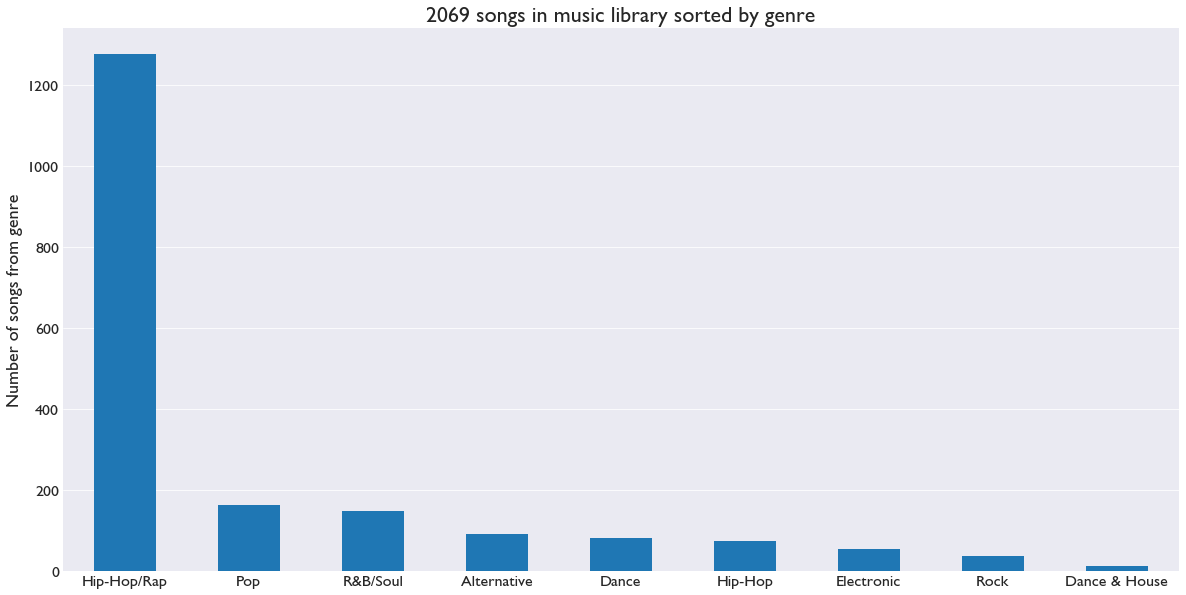

In [5]:
def library_genre():
    genre_bar = library_data["Genre"].value_counts()
    genre_bar[genre_bar > 10].plot(kind='bar')
    plt.ylabel('Number of songs from genre', fontsize=18, fontfamily='Gill Sans MT')
    plt.title('{} songs in music library sorted by genre'.format(str(len(library_data['Title']))),              fontsize=22, fontfamily='Gill Sans MT')
    plt.xticks(fontsize=16, fontfamily='Gill Sans MT', rotation='horizontal')
    plt.yticks(fontsize=16, fontfamily='Gill Sans MT')
    plt.axes().yaxis.grid()
    plt.style.use('seaborn-dark')
    
    return plt.show()

library_genre()

We can see that there's a clear outlier of Hip-Hop/Rap which defines the majority of songs in my library (over 1200). This graph only shows the top 10 genres because the distribution has a long tail of genres which aren't attributed to many songs.

tl.dr: I'm a big hip-hop fan

What about how I listen to these genres? What if I just have a lot of hip-hop because my friends like it and I secretly love country and classical? We can shift over to my listening dataset and filter it by songs that I have fully listened to (without skipping/pausing etc.) and plot them by genre.

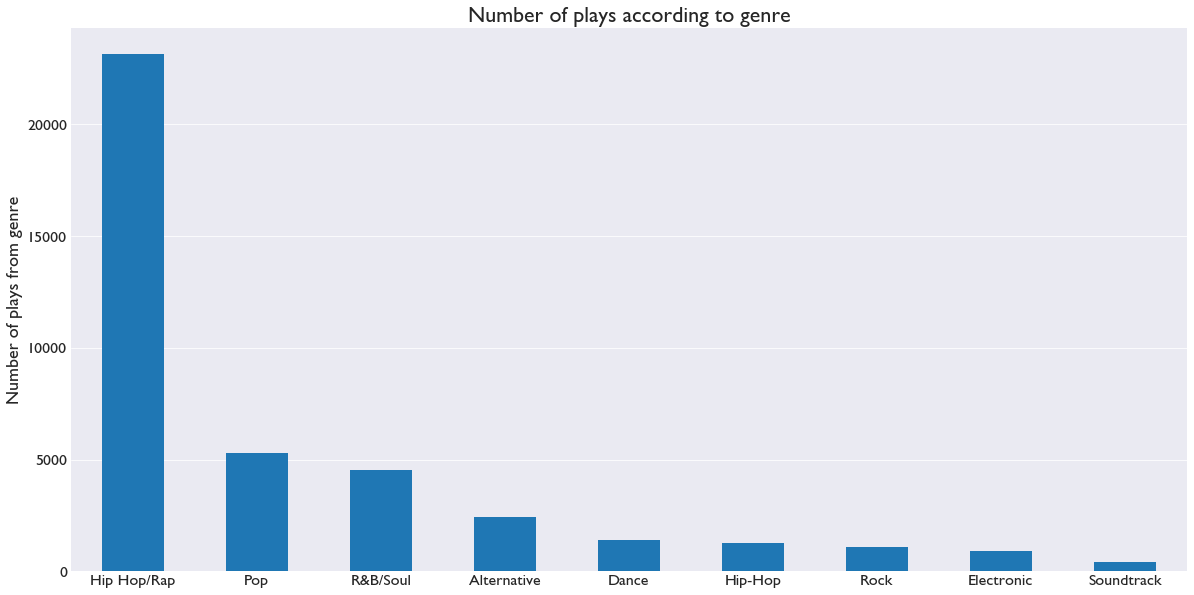

In [6]:
def listening_genre():
    full_songs = listening_data[listening_data['End Reason Type'] == 'NATURAL_END_OF_TRACK']
    full_songs['Genre'].value_counts()[0:9].plot(kind='bar')
    plt.ylabel('Number of plays from genre', fontsize=18, fontfamily='Gill Sans MT')
    plt.title('Number of plays according to genre', fontsize=22, fontfamily='Gill Sans MT')
    plt.xticks(fontsize=16, fontfamily='Gill Sans MT', rotation='horizontal')
    plt.yticks(fontsize=16, fontfamily='Gill Sans MT')
    plt.axes().yaxis.grid()
    plt.style.use('seaborn-dark')
    
    return plt.show()

listening_genre()

The two graphs have an almost identical distribution by genre. This would show (in a crude way) that I listen to songs in the same proportion that they are distributed by genre in my library. ie. I listen to my library the exact way that I've added songs to it (who would've known)

What about year of release? 

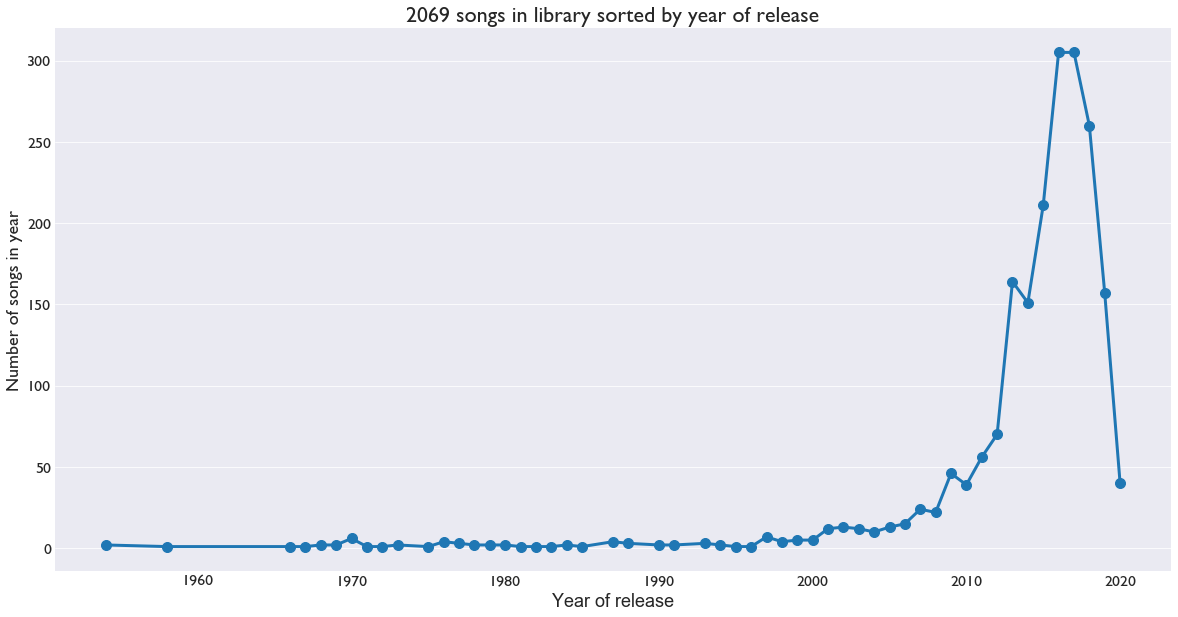

In [7]:
def year_of_release():
    music_year = library_data['Track Year'][library_data['Track Year'] != 0].value_counts().sort_index().plot(marker= 'o', markersize=10, linewidth=3)
    plt.xlabel('Year of release', fontsize=18)
    plt.ylabel('Number of songs in year', fontsize=18, fontfamily='Gill Sans MT')
    plt.title('{} songs in library sorted by year of release'.format(len(library_data['Track Year'])),          fontsize=22, fontfamily='Gill Sans MT')
    plt.xticks(fontsize=16, fontfamily='Gill Sans MT')
    plt.yticks(fontsize=16, fontfamily='Gill Sans MT')
    plt.axes().yaxis.grid()

    return plt.show()
year_of_release()

It seems like I mostly listen to current music (2010s and onwards) with a left skewed distribution and outliers from 1950s to 2000s. When looking at this graph, it's important to keep in mind that I got the account in 2016 which would most likely explain the sharp spike in 2016 and 2017. Since then it looks like I've either not added much music or not added much _current_ music.

We can understand the previous graph a lot better if we compare it with date added to library.

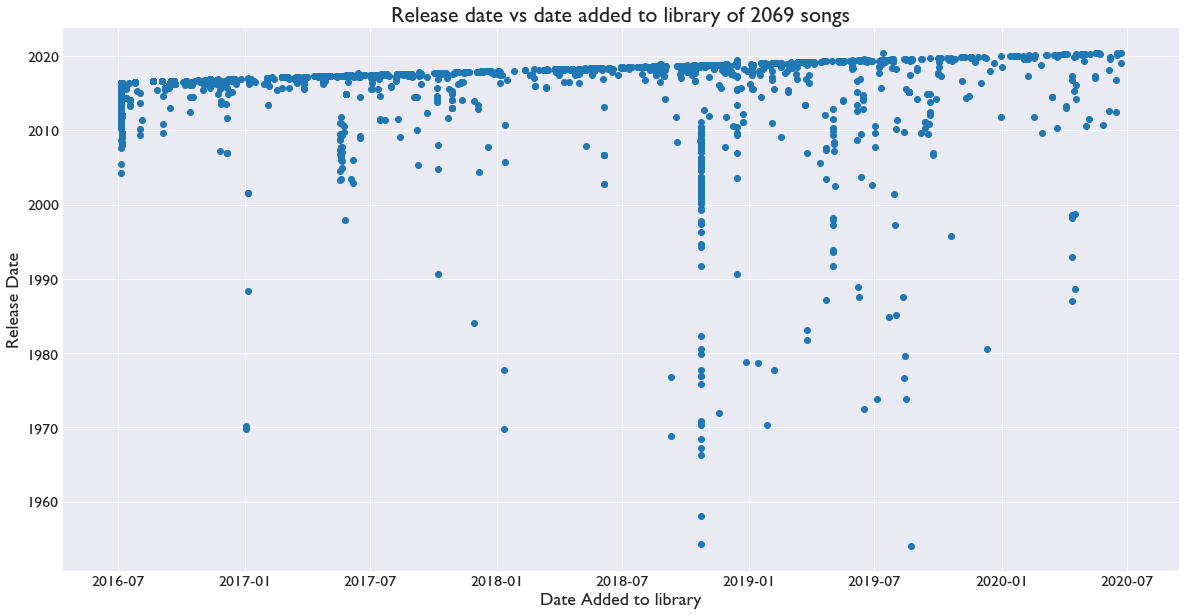

In [8]:
def ReleaseDate_v_DateAdded():
    fig, ax = plt.subplots(1)
    x=library_data['Date Added To Library']
    y=library_data['Release Date']
    plt.scatter(x, y)
    plt.title('Release date vs date added to library of {} songs'.format(len(library_data)),                    fontsize=22, fontfamily='Gill Sans MT')
    plt.ylabel('Release Date', fontsize=18, fontfamily='Gill Sans MT')
    plt.xlabel('Date Added to library', fontsize=18, fontfamily='Gill Sans MT')
    plt.xticks(fontsize=16, fontfamily='Gill Sans MT')
    plt.yticks(fontsize=16, fontfamily='Gill Sans MT')
    plt.grid(True)
    
    
    return plt.show()

ReleaseDate_v_DateAdded()

Now we can see how I really add music based on release date. There's a notable positive linear correlation towards the top of the graph which indicates that as time goes by, most of the time I am adding current music of that year. 

We can also see some vertical outliers which occur all at once. These would indicate that in a short time period (day/week), I have added many songs which aren't recent. There are 3 notable cases of this where I seem to have gone on a nostalgia trip and added a bundle of old songs all at once. The largest is around September/October 2018. 

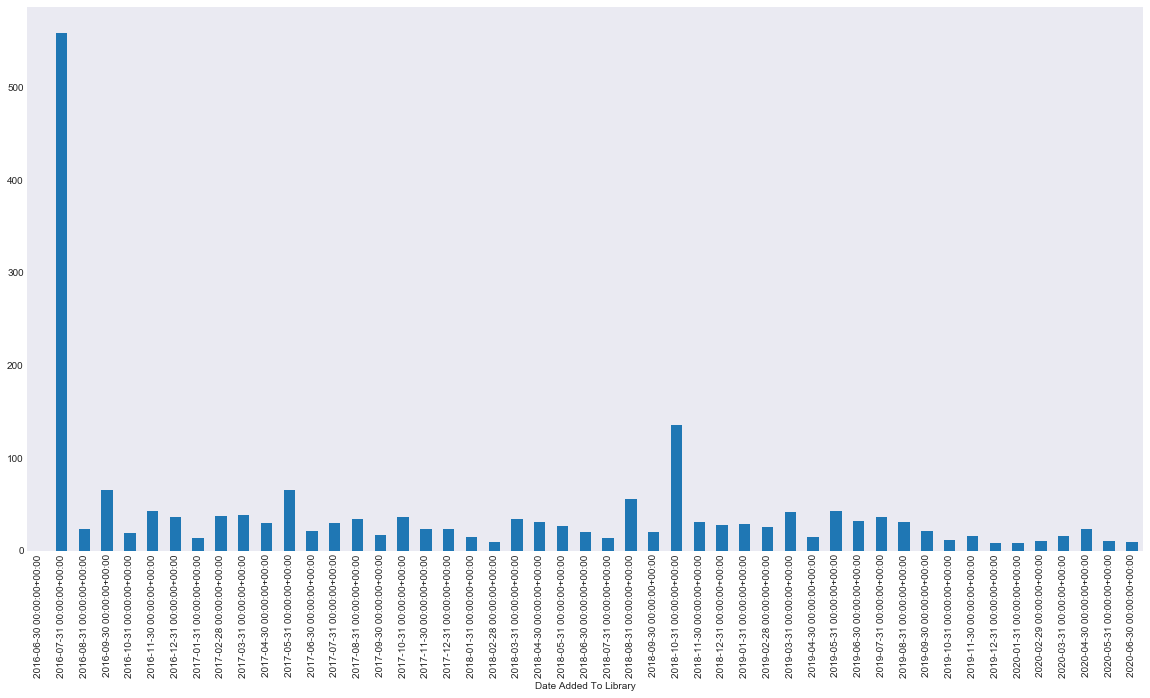

In [9]:
library_data.set_index('Date Added To Library').groupby(pd.Grouper(freq = 'M')).count()            ['Content Type'][31:80].plot(kind='bar')

We can also have a look at how I listen to songs based on their related projects and their type. Does my library mainly have singles? Albums? EPs?

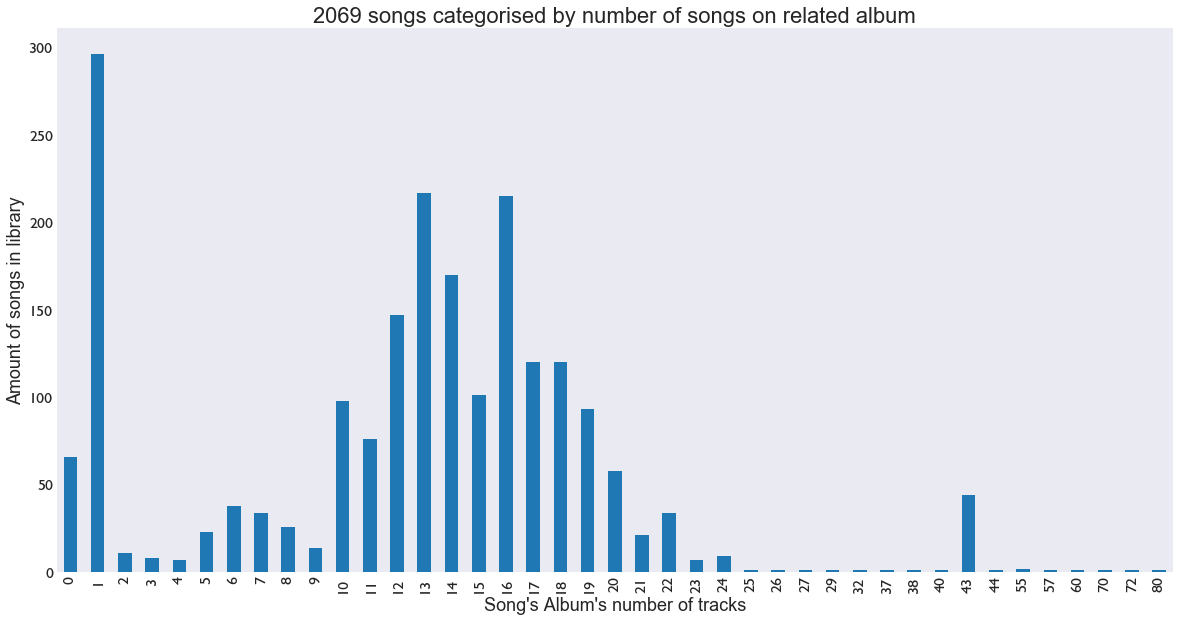

In [10]:
def song_project_track_numbers():
    library_data['Track Count On Album'].value_counts().sort_index().plot(kind='bar')
    plt.xlabel("Song's Album's number of tracks", fontsize=18)
    plt.ylabel("Amount of songs in library", fontsize=18)
    plt.title('{} songs categorised by number of songs on related album'.format(len(library_data)),             fontsize=22)
    plt.xticks(fontsize=16, fontfamily='Gill Sans MT')
    plt.yticks(fontsize=16, fontfamily='Gill Sans MT')
    
song_project_track_numbers()

Based on the previous graph, I've got a fair amount of singles but my library mostly has songs which belong to a project which is longer than 1 song. The albums which have '0 songs' are actually added externally from a downloaded source rather than a streamed source. The spike at 43 comes from a ministry of sound compilation album that I downloaded which had 43 songs in it.

There are 3 noticeable peaks in this graph which categorise the 3 main types of projects which are available in music. The single peak at 1, the small peak around 6-7 which defines songs from EPs, and the large peak around 14-16 from full length studio albums.

What about the distribution of features in my library? How many songs have more than 1 artist and how many are solo songs?

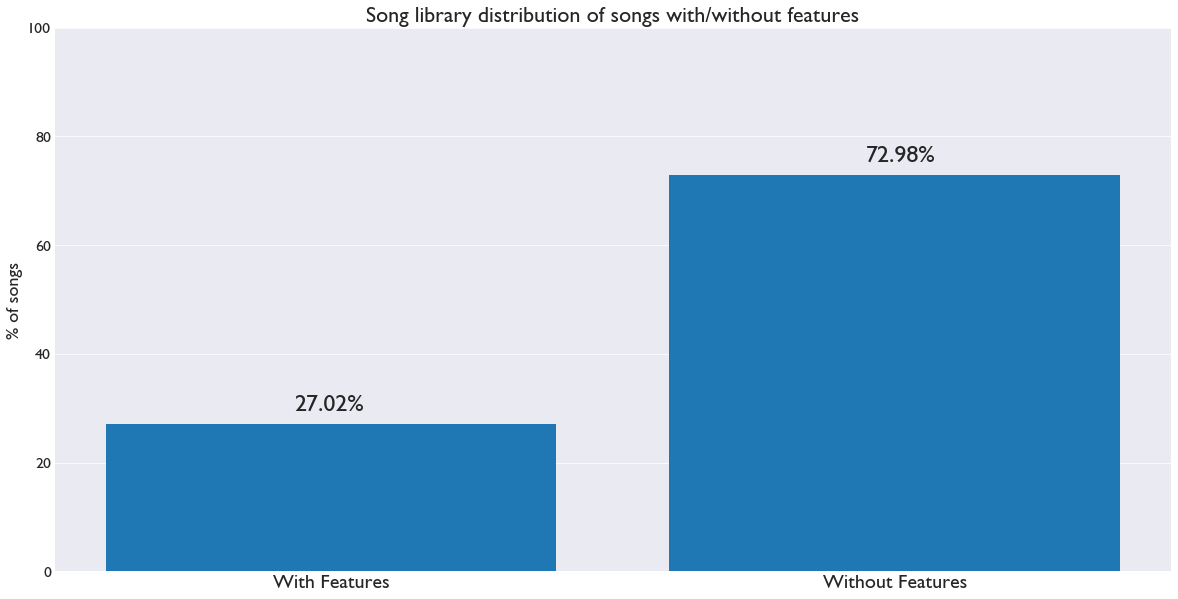

In [11]:
def song_features():
    features = ['feat.' in song for song in library_data['Title']]
    true_count = 0
    false_count = 0
    for i in features:
        if i == True:
            true_count += 100/2069
        if i == False:
            false_count += 100/2069
    x_titles = ['With Features', 'Without Features']
    feature_count = [true_count, false_count]
    x_pos = [i for i, _ in enumerate(x_titles)]
    plt.ylim(0, 100)
    plt.bar(x_pos, feature_count)
    plt.xticks(x_pos, x_titles, fontsize=20, fontfamily='Gill Sans MT')
    plt.yticks(fontsize=16, fontfamily='Gill Sans MT')
    plt.annotate(str('%.2f' % true_count) + '%', xy=(0.25,0.315), xycoords='figure fraction', fontsize=24,      fontfamily='Gill Sans MT')
    plt.annotate(str('%.2f' % false_count) + '%', xy=(0.735,0.73), xycoords='figure fraction', fontsize=24,     fontfamily='Gill Sans MT')
    plt.ylabel('% ' + 'of songs', fontsize=18, fontfamily='Gill Sans MT')
    plt.title('Song library distribution of songs with/without features', fontsize=22, fontfamily='Gill Sans MT')
    plt.axes().yaxis.grid()

song_features()

I found this to be quite unorthodox. That a quarter of my songs have more than 1 artist in them (I was expecting much less). 

We can also have a look at the _durations_ of songs within my library. Usually genres have different song lengths (rock/rocknroll typically has much longer song lengths from artists like Led Zeppelin, Pink Floyd etc.). So I wondered if my library had standard song lengths (~3-4mins) or if it was unique.

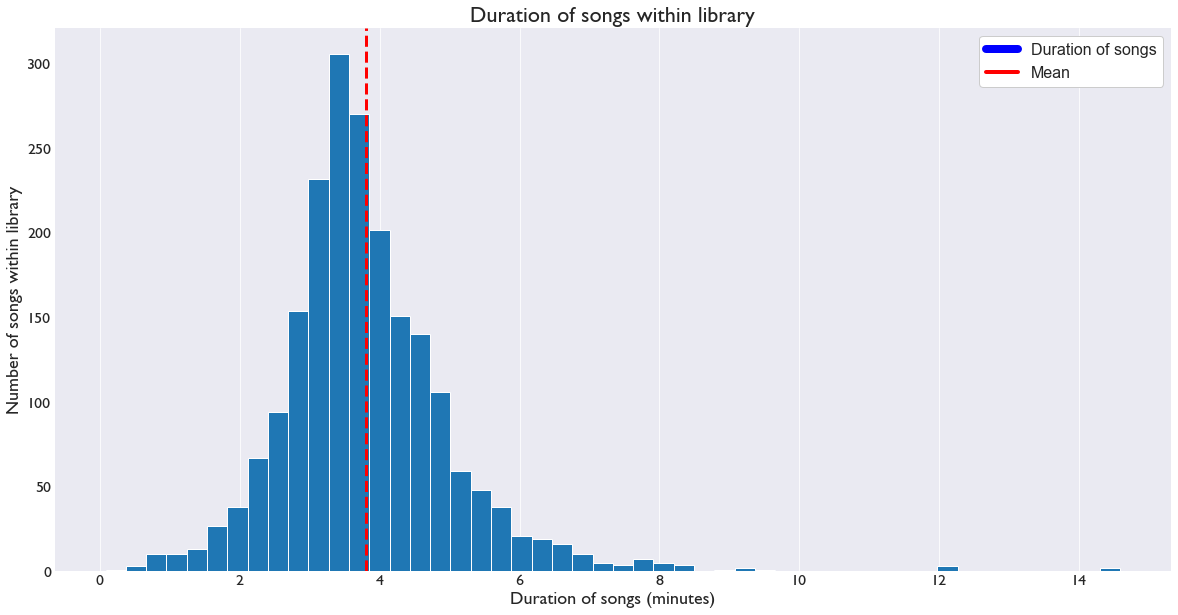

In [12]:
def song_durations():
    from matplotlib.lines import Line2D
    legend_lines = [Line2D([0], [0], color='blue', lw=8),
                    Line2D([0], [0], color='red', lw=4)]

    library_data["track_duration_minutes"] = library_data["Track Duration"] / 60000
    x = library_data["track_duration_minutes"].mean()
    library_data["track_duration_minutes"].hist(bins=50, edgecolor='white')
    plt.xlabel('Duration of songs (minutes)', fontsize=18, fontfamily='Gill Sans MT')
    plt.ylabel('Number of songs within library', fontsize=18, fontfamily='Gill Sans MT')
    plt.title('Duration of songs within library', fontsize=22, fontfamily='Gill Sans MT')
    plt.xticks(fontsize=16, fontfamily='Gill Sans MT')
    plt.yticks(fontsize=16, fontfamily='Gill Sans MT')
    plt.axvline(x, color='red', linestyle='dashed', linewidth=3)
    plt.legend(legend_lines, ['Duration of songs', 'Mean'], fontsize = 16, frameon=True,                  facecolor='white', framealpha=1)
    plt.axes().yaxis.grid()

    return plt.show()

song_durations()

Unfortunately, no suprises here. A normal distribution with a mean of around 3.8 minutes which I thought was very typical. But there are outliers above 10 minutes and I was interested to see what my longest/shortest songs were.

In [13]:
library_data["track_duration_minutes"] = library_data["Track Duration"] / (1000*60)
titles_minutes = library_data[['Title', 'Artist', 'track_duration_minutes']]
titles_minutes[titles_minutes['track_duration_minutes'] > 10]


,Title,Artist,track_duration_minutes
84,Note to Self,J. Cole,14.588083
217,Mortal Man,Kendrick Lamar,12.118367
227,"Sing About Me, I'm Dying of Thirst",Kendrick Lamar,12.059667
1015,AfricAryaN (feat. Neil deGrasse Tyson),Logic,12.140050
1064,Note to Self,J. Cole,14.588083


A lot of these songs are either towards the end of an album where the artist is doing their tributes and thankyous, or are extended skits/interludes.

In [14]:
library_data["track_duration_seconds"] = library_data["Track Duration"] / 1000
titles_seconds = library_data[['Title', 'Artist', 'track_duration_seconds']]
titles_seconds[titles_seconds.track_duration_seconds < 60]

,Title,Artist,track_duration_seconds
0,The Library (Intro),Childish Gambino,4.812
3,Dial Up,Childish Gambino,44.536
9,Playing Around Before the Party Starts,Childish Gambino,54.454
12,Death By Numbers,Childish Gambino,43.968
47,The Cube (Scene),Logic,27.235
55,Lucidity (Scene),Logic,55.807
86,Kerney Sermon (Skit),J. Cole,46.067
94,Where's Jermaine? (Skit),J. Cole,36.667
161,I Love Kanye,Kanye West,44.827
166,Frank's Track,Kanye West,38.333


A lot of these sub 60 second songs are short interludes between actual songs on an album where the artist tries to do a skit which tries to match the theme of the album (ie. Makes the album more unique and gives it a greater story and continuity)

Now that we've looked at the library data, we can look into the listening data to see if there's anything interesting to see.

In [15]:
pd.options.display.max_columns = None
listening_data

,Apple Id Number,Apple Music Subscription,Artist Name,Build Version,Client IP Address,Content Name,Content Provider,Content Specific Type,Device Identifier,End Position In Milliseconds,End Reason Type,Event End Timestamp,Event Reason Hint Type,Event Received Timestamp,Event Start Timestamp,Event Type,Feature Name,Genre,Item Type,Media Duration In Milliseconds,Media Type,Metrics Bucket Id,Metrics Client Id,Milliseconds Since Play,Offline,Original Title,Play Duration Milliseconds,Source Type,Start Position In Milliseconds,Store Country Name,UTC Offset In Seconds
0,358953842,True,Usher,"Music/3.1 iOS/10.3.1 model/iPhone6,2 hwp/s5l89...",58.168.9.126,U Remind Me,Sony Music,Song,79b330a05a148bd8cc479948ccb6f843db1af063,29198.0,SCRUB_END,2017-05-24T04:45:32.421Z,NOT_SPECIFIED,2017-05-24T04:45:41.139Z,2017-05-24 04:45:07.117000+00:00,PLAY_END,search,R&B/Soul,ITUNES_STORE_CONTENT,266959.0,AUDIO,9459.0,3z4Rpr37z4qOz4dQzAFIz1DqXrfTQc,8718,False,NaN,25304.0,ORIGINATING_DEVICE,3894,Australia,36000
1,358953842,True,Anastacia,"Music/3.1 iOS/12.2 model/iPhone8,1 hwp/s8000 b...",2001:8003:2064:9300:8965:15b6:ca54:d28a,Left Outside Alone,Sony Music,Song,458d24b37aa0e1eba6341f6f7ee4c70aee891796,1238.0,SCRUB_BEGIN,2019-04-22T01:25:46.439Z,NOT_SPECIFIED,2019-04-22T01:25:48.546Z,2019-04-22 01:25:45.201000+00:00,PLAY_END,search / playlist_detail,Pop,ITUNES_STORE_CONTENT,258856.0,AUDIO,8552.0,3z3LHatpzH4nz4lszA0hz19OoAg8Tl,2107,False,NaN,1238.0,ORIGINATING_DEVICE,0,Australia,36000
2,358953842,True,Coldplay,"Music/3.1 iOS/13.3.1 model/iPhone8,1 hwp/s8000...",2001:8003:30cc:7f00:4b3:cac9:c4ff:afb1,Paradise,The Warner Music Group,Song,458d24b37aa0e1eba6341f6f7ee4c70aee891796,1351.0,PLAYBACK_MANUALLY_PAUSED,2020-02-17T03:48:47.549Z,NOT_SPECIFIED,2020-02-17T03:48:48.314Z,2020-02-17 03:48:46.198000+00:00,PLAY_END,library / songs,Alternative,ITUNES_STORE_CONTENT,277664.0,AUDIO,9278.0,3z3NMROKz46xz4SUzAeXz1GOvIePN9,765,False,NaN,1351.0,ORIGINATING_DEVICE,0,Australia,39600
3,358953842,True,Coldplay,"Music/3.1 iOS/13.3.1 model/iPhone8,1 hwp/s8000...",2001:8003:30cc:7f00:60cf:13ba:ea5a:a1e6,Paradise,The Warner Music Group,Song,458d24b37aa0e1eba6341f6f7ee4c70aee891796,277664.0,NATURAL_END_OF_TRACK,2020-03-09T08:05:35.179Z,NOT_SPECIFIED,2020-03-09T08:05:35.281Z,2020-03-09 08:00:57.515000+00:00,PLAY_END,library / songs,Alternative,ITUNES_STORE_CONTENT,277664.0,AUDIO,9278.0,3z3NMROKz46xz4SUzAeXz1GOvIePN9,102,False,NaN,277664.0,ORIGINATING_DEVICE,0,Australia,39600
4,358953842,True,Coldplay,"Music/3.1 iOS/13.4.1 model/iPhone8,1 hwp/s8000...",2001:8003:30cc:7f00:7d75:97d5:3cd7:c60c,Paradise,The Warner Music Group,Song,458d24b37aa0e1eba6341f6f7ee4c70aee891796,686.0,TRACK_SKIPPED_FORWARDS,2020-06-01T02:04:11.579Z,NOT_SPECIFIED,2020-06-01T02:04:20.803Z,2020-06-01 02:04:10.893000+00:00,PLAY_END,library / songs,Alternative,ITUNES_STORE_CONTENT,277664.0,AUDIO,9278.0,3z3NMROKz46xz4SUzAeXz1GOvIePN9,9224,False,NaN,686.0,ORIGINATING_DEVICE,0,Australia,36000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128732,358953842,True,Drake,"Music/3.0 iOS/10.0.1 model/iPhone6,2 hwp/s5l89...",121.212.120.118,Pop Style,Universal Music International,Song,79b330a05a148bd8cc479948ccb6f843db1af063,213019.0,NATURAL_END_OF_TRACK,2017-01-30T05:32:11.149Z,NOT_SPECIFIED,2017-01-30T05:52:32.073Z,2017-01-30 05:28:38.130000+00:00,PLAY_END,library / albums / album_detail,Hip Hop/Rap,ITUNES_STORE_CONTENT,213019.0,AUDIO,1393.0,3z1Cf16Uz8ltz4r5zBt2z1AfCS6iOS,1220924,True,NaN,213019.0,ORIGINATING_DEVICE,0,Australia,39600
128733,358953842,True,DJ Khaled,"Music/3.1 iOS/10.3.1 model/iPhone6,2 hwp/s5l89...",58.167.58.7,Wild Thoughts (feat. Rihanna & Bryson Tiller),Sony Music,Song,79b330a05a148bd8cc479948ccb6f843db1af063,109301.0,SCRUB_END,2017-06-19T13:31:09.239Z,NOT_SPECIFIED,2017-06-19T13:31:43.634Z,2017-06-19 13:30:31.545000+00:00,PLAY_END,browse / browse / grouping,Hip Hop/Rap,ITUNES_STORE_CONTENT,204242.0,AUDIO,9459.0,3z4Rpr

In [16]:
listening_data.columns

Index(['Apple Id Number', 'Apple Music Subscription', 'Artist Name',
       'Build Version', 'Client IP Address', 'Content Name',
       'Content Provider', 'Content Specific Type', 'Device Identifier',
       'End Position In Milliseconds', 'End Reason Type',
       'Event End Timestamp', 'Event Reason Hint Type',
       'Event Received Timestamp', 'Event Start Timestamp', 'Event Type',
       'Feature Name', 'Genre', 'Item Type', 'Media Duration In Milliseconds',
       'Media Type', 'Metrics Bucket Id', 'Metrics Client Id',
       'Milliseconds Since Play', 'Offline', 'Original Title',
       'Play Duration Milliseconds', 'Source Type',
       'Start Position In Milliseconds', 'Store Country Name',
       'UTC Offset In Seconds'],
      dtype='object')

In [17]:
listening_data['End Reason Type'].value_counts()

NATURAL_END_OF_TRACK                         41732
TRACK_SKIPPED_FORWARDS                       33158
PLAYBACK_MANUALLY_PAUSED                     19246
MANUALLY_SELECTED_PLAYBACK_OF_A_DIFF_ITEM    14850
SCRUB_END                                     7626
SCRUB_BEGIN                                   7626
TRACK_SKIPPED_BACKWARDS                       2084
NOT_APPLICABLE                                 116
FAILED_TO_LOAD                                 115
PLAYBACK_STOPPED_DUE_TO_SESSION_TIMEOUT          1
Name: End Reason Type, dtype: int64

Although the listening dataset has ~128000 rows, not all of them are songs that I've listened to the full length through. For convenience, we can filter the dataset to get the actual list of songs that I've listened to and the songs I've skipped

In [123]:
full_songs = listening_data[listening_data['End Reason Type'] == 'NATURAL_END_OF_TRACK']
skipped_songs = listening_data[listening_data['End Reason Type'] == 'TRACK_SKIPPED_FORWARDS']

time_range = library_data['Date Added To Library'][2068] - library_data['Date Added To Library'][0]
full_songs['Australian timezone'] = full_songs['Event Start Timestamp'].dropna().apply(lambda x: x.astimezone('Australia/Sydney').to_pydatetime())
full_songs['Year listened'] = full_songs['Event Start Timestamp'].apply(lambda x: x.year)
full_songs['Month listened'] = full_songs['Event Start Timestamp'].apply(lambda x: x.month)
full_songs['Day listened'] = full_songs['Event Start Timestamp'].apply(lambda x: x.weekday)
full_songs['Hour listened'] = full_songs['Australian timezone'].apply(lambda x: x.hour)

skipped_songs['Australian timezone'] = skipped_songs['Event Start Timestamp'].dropna().apply(lambda x: x.astimezone('Australia/Sydney').to_pydatetime())
skipped_songs['Year skipped'] = skipped_songs['Event Start Timestamp'].apply(lambda x: x.year)
skipped_songs['Month skipped'] = skipped_songs['Event Start Timestamp'].apply(lambda x: x.month)
skipped_songs['Day skipped'] = skipped_songs['Event Start Timestamp'].apply(lambda x: x.weekday)
skipped_songs['Hour skipped'] = skipped_songs['Australian timezone'].apply(lambda x: x.hour)

,Apple Id Number,Apple Music Subscription,Artist Name,Build Version,Client IP Address,Content Name,Content Provider,Content Specific Type,Device Identifier,End Position In Milliseconds,End Reason Type,Event End Timestamp,Event Reason Hint Type,Event Received Timestamp,Event Start Timestamp,Event Type,Feature Name,Genre,Item Type,Media Duration In Milliseconds,Media Type,Metrics Bucket Id,Metrics Client Id,Milliseconds Since Play,Offline,Original Title,Play Duration Milliseconds,Source Type,Start Position In Milliseconds,Store Country Name,UTC Offset In Seconds,Australian timezone,Year skipped,Month skipped,Day skipped,Hour skipped
4,358953842,True,Coldplay,"Music/3.1 iOS/13.4.1 model/iPhone8,1 hwp/s8000...",2001:8003:30cc:7f00:7d75:97d5:3cd7:c60c,Paradise,The Warner Music Group,Song,458d24b37aa0e1eba6341f6f7ee4c70aee891796,686.0,TRACK_SKIPPED_FORWARDS,2020-06-01T02:04:11.579Z,NOT_SPECIFIED,2020-06-01T02:04:20.803Z,2020-06-01 02:04:10.893000+00:00,PLAY_END,library / songs,Alternative,ITUNES_STORE_CONTENT,277664.0,AUDIO,9278.0,3z3NMROKz46xz4SUzAeXz1GOvIePN9,9224,False,NaN,686.0,ORIGINATING_DEVICE,0,Australia,36000,2020-06-01 12:04:10.893000+10:00,2020.0,6.0,0.0,12.0
7,358953842,True,MadeinTYO,"Music/3.1 iOS/12.4 model/iPhone8,1 hwp/s8000 b...",120.18.162.126,Lil Bih (feat. 24hrs),The Warner Music Group,Song,458d24b37aa0e1eba6341f6f7ee4c70aee891796,316.0,TRACK_SKIPPED_FORWARDS,2019-09-03T00:56:33.790Z,NOT_SPECIFIED,2019-09-03T00:56:33.925Z,2019-09-03 00:56:33.474000+00:00,PLAY_END,library / albums,Hip Hop/Rap,ITUNES_STORE_CONTENT,170062.0,AUDIO,4589.0,3z2uIdPHzEsYz59hz9trzygSQbDwM,135,False,NaN,316.0,ORIGINATING_DEVICE,0,Australia,36000,2019-09-03 10:56:33.474000+10:00,2019.0,9.0,1.0,10.0
8,358953842,True,Anderson .Paak,"Music/3.1 iOS/12.0 model/iPhone8,1 hwp/s8000 b...",120.18.72.227,Tints (feat. Kendrick Lamar),The Warner Music Group,Song,458d24b37aa0e1eba6341f6f7ee4c70aee891796,2936.0,TRACK_SKIPPED_FORWARDS,2018-11-22T06:01:57.399Z,NOT_SPECIFIED,2018-11-22T06:01:57.627Z,2018-11-22 06:01:54.463000+00:00,PLAY_END,library / playlist_detail,Hip Hop/Rap,ITUNES_STORE_CONTENT,268469.0,AUDIO,3974.0,3z49j34Uz5R4z4iCz9taz1Kn3j664k,228,False,NaN,2936.0,ORIGINATING_DEVICE,0,Australia,39600,2018-11-22 17:01:54.463000+11:00,2018.0,11.0,3.0,17.0
9,358953842,True,Logic,"Music/3.1 iOS/12.4.1 model/iPhone8,1 hwp/s8000...",120.18.49.67,Out of Sight,UMG Global,Song,458d24b37aa0e1eba6341f6f7ee4c70aee891796,279.0,TRACK_SKIPPED_FORWARDS,2019-09-10T00:29:10.991Z,NOT_SPECIFIED,2019-09-10T00:45:01.728Z,2019-09-10 00:29:10.712000+00:00,PLAY_END,library / songs,Hip Hop/Rap,ITUNES_STORE_CONTENT,137996.0,AUDIO,4589.0,3z2uIdPHzEsYz59hz9trzygSQbDwM,950737,True,NaN,279.0,ORIGINATING_DEVICE,0,Australia,36000,2019-09-10 10:29:10.712000+10:00,2019.0,9.0,1.0,10.0
12,358953842,True,Kendrick Lamar,"Music/3.0 iOS/10.0.1 model/iPhone6,2 hwp/s5l89...",58.166.212.49,i,Universal Music International,Song,79b330a05a148bd8cc479948ccb6f843db1af063,134975.0,TRACK_SKIPPED_FORWARDS,2017-01-10T04:54:31.101Z,NOT_SPECIFIED,2017-01-10T05:36:26.547Z,2017-01-10 04:54:28.213000+00:00,PLAY_END,library / albums,Hip Hop/Rap,ITUNES_STORE_CONTENT,336062.0,AUDIO,1393.0,3z1Cf16Uz8ltz4r5zBt2z1AfCS6iOS,2515446,True,NaN,2888.0,ORIGINATING_DEVICE,132087,Australia,39600,2017-01-10 15:54:28.213000+11:00,2017.0,1.0,1.0,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128702,358953842,True,Joey Bada$$,"Music/3.1 iOS/11.4.1 model/iPhone8,1 hwp/s8000...",60.227.47.190,TEMPTATION,The Orchard Enterprises Inc.,Song,458d24b37aa0e1eba6341f6f7ee4c70aee891796,1911.0,TRACK_SKIPPED_FORWARDS,2018-09-25T13:33:47.640Z,NOT_SPECIFIED,2018-09-25T13:33:48.132Z,2018-09-25 13:33:45.729000+00:00,PLAY_END,library / albums,Hip Hop/Rap,ITUNES_STORE_CONTENT,244250.0,AUDIO,6999.0,3z4yEJmpzCpFz5G4z93yzXbi1I7UU,492,False,NaN,1911.0,ORIGINATING_DEVICE,0,Australia,36000,2018-09-25 23:33:45.729000+10:00,2018.0,9.0,1.0,23.0
128

In [194]:
data = full_songs.groupby(['Genre', 'Year listened'])['Event Start Timestamp'].count().unstack()
data

Year listened,2016.0,2017.0,2018.0,2019.0,2020.0
Genre,,,,,
Adult Alternative,NaN,NaN,NaN,NaN,1.0
Afrobeats,NaN,NaN,NaN,114.0,9.0
Alternative,18.0,76.0,288.0,1446.0,580.0
Alternative Rap,NaN,NaN,25.0,NaN,2.0
Anime,NaN,NaN,2.0,NaN,NaN
Breakbeat,NaN,NaN,1.0,23.0,1.0
Children's Music,6.0,NaN,NaN,NaN,2.0
Christian & Gospel,NaN,NaN,2.0,NaN,NaN
Classical Crossover,NaN,NaN,NaN,NaN,18.0


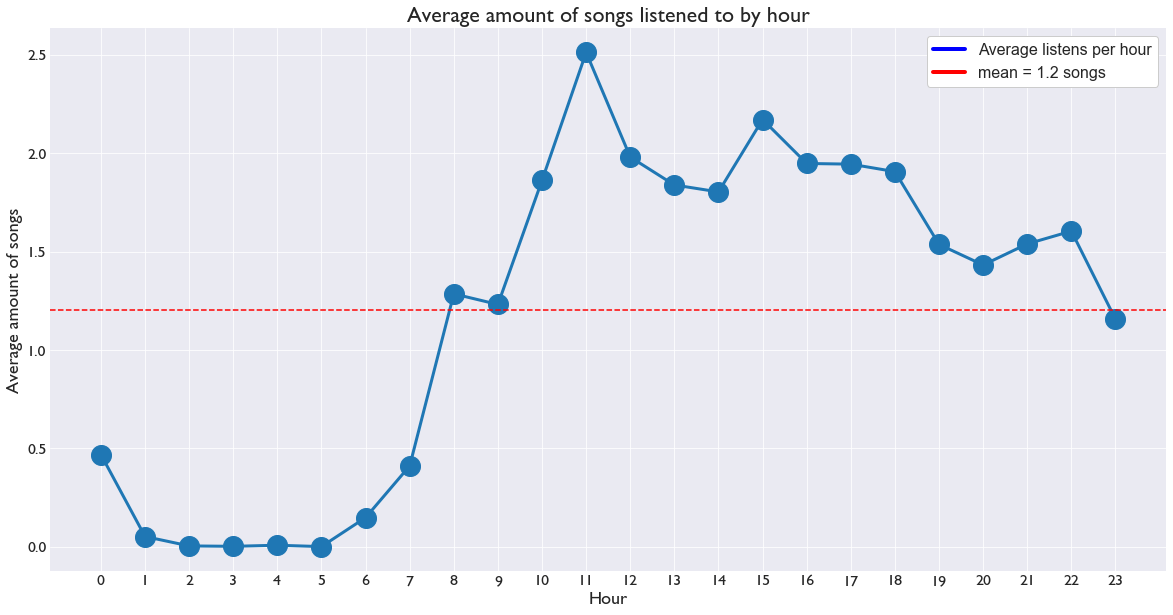

In [51]:
def songs_by_hour():
    from matplotlib.lines import Line2D
    hour_counts = full_songs['Australian timezone'].apply(lambda x: x.hour).value_counts() / time_range.days
    average = hour_counts.mean()
    legend_lines = [Line2D([0], [0], color='blue', lw=4),
                    Line2D([0], [0], color='red', lw=4)]

    hour_counts.sort_index().plot(marker= 'o', markersize=20, linewidth=3)
    plt.xticks(np.arange(24), range(0,24), fontsize=16, family='Gill Sans MT')
    plt.yticks(fontsize=16, family='Gill Sans MT')
    plt.ylabel('Average amount of songs', fontsize=18, family='Gill Sans MT')
    plt.xlabel('Hour', fontsize=18, family='Gill Sans MT')
    plt.title('Average amount of songs listened to by hour', fontsize=22, family='Gill Sans MT')
    plt.axhline(y=average, color='r', linestyle='--')
    plt.grid(True)
    plt.legend(legend_lines, ['Average listens per hour', 'mean = {} songs'.format(round(average, 1))], fontsize = 16, frameon=True,facecolor='white', framealpha=1)
    return plt.show()

songs_by_hour()

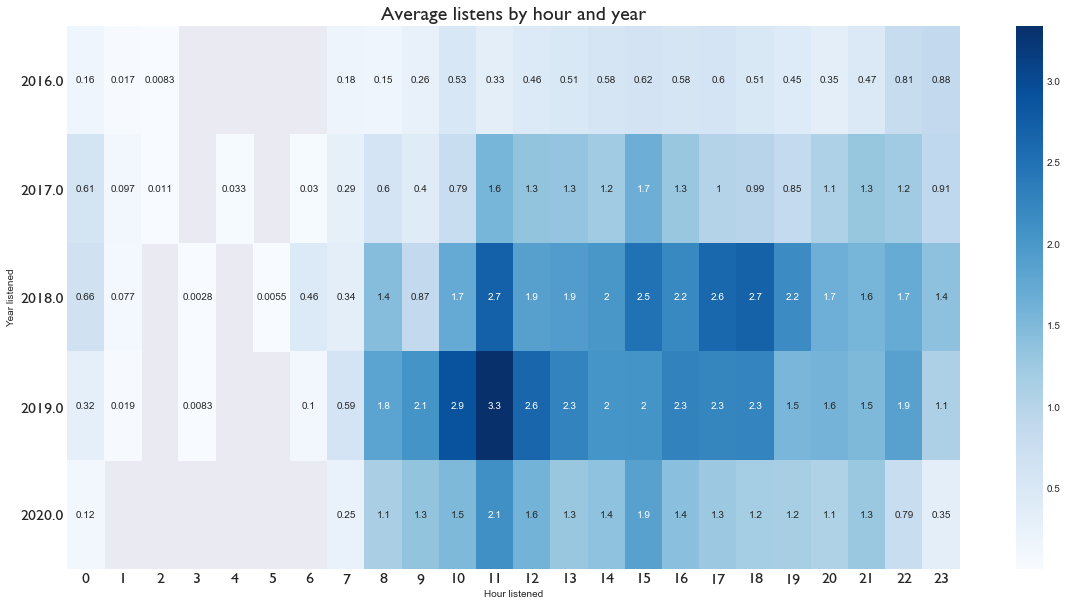

In [144]:
def songs_by_houryear():
    data = (full_songs.groupby(['Year listened', 'Hour listened'])['Event Start Timestamp'].count() / (time_range.days / 4)).unstack()
    sb.heatmap(data, cmap='Blues', annot=True)
    plt.xticks(np.arange(24) + 0.5, range(0,24),fontsize=16, fontfamily='Gill Sans MT')
    plt.yticks(fontsize=16, fontfamily='Gill Sans MT', rotation='horizontal')
    plt.title('Average listens by hour and year', fontsize=20, fontfamily='Gill Sans MT')
    #cbar.set_label('Average plays', rotation=90, fontsize=18, fontfamily='Gill Sans MT')

    return plt.show()
songs_by_houryear()

Text(0.5, 1, 'Amount of songs skipped by hour and year on average')

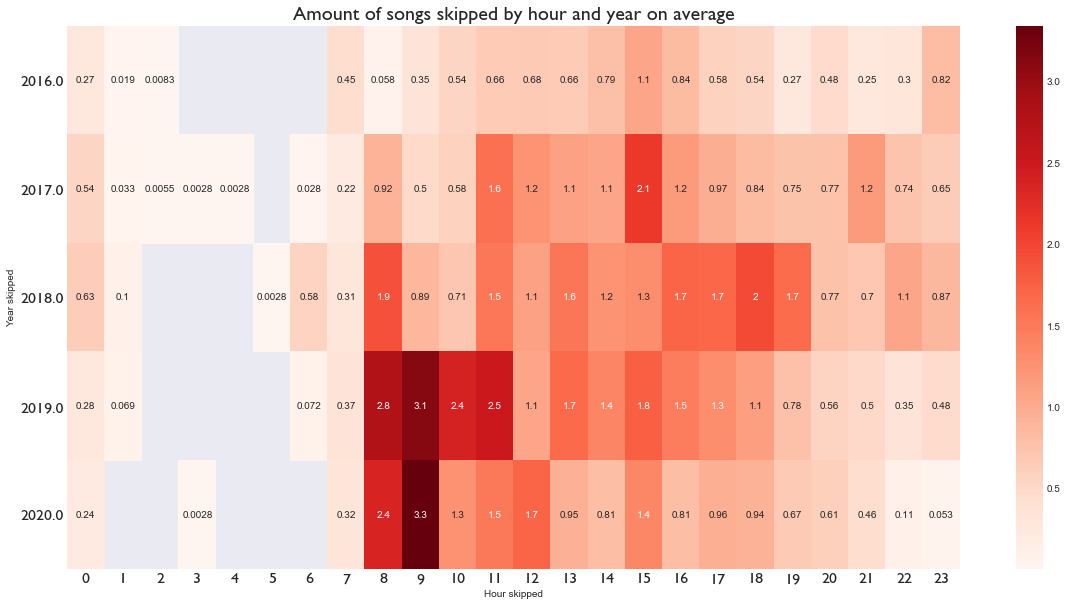

In [126]:
def skips_by_houryear():
    data = (skipped_songs.groupby(['Year skipped', 'Hour skipped'])['Event Start Timestamp'].count() / (time_range.days / 4)).unstack()
    sb.heatmap(data, cmap='Reds', annot=True)
    plt.xticks(np.arange(24) + 0.5, range(0,24),fontsize=16, fontfamily='Gill Sans MT')
    plt.yticks(fontsize=16, fontfamily='Gill Sans MT', rotation='horizontal')
    plt.title('Amount of songs skipped by hour and year on average', fontsize=20, fontfamily='Gill Sans MT')

    return plt.show()
skips_by_houryear()

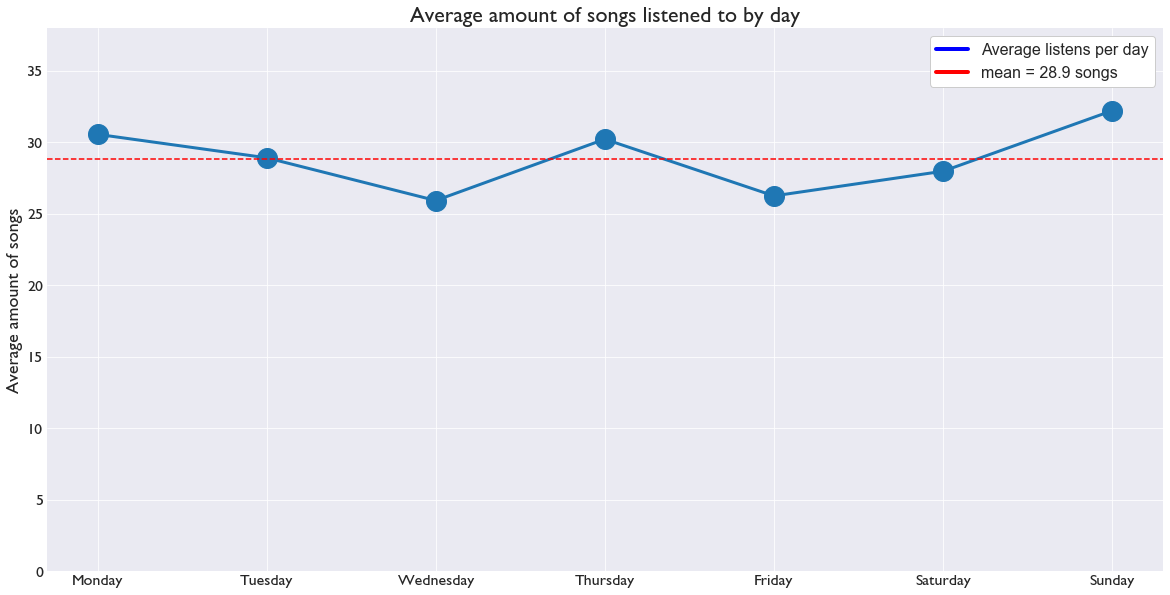

In [52]:
def songs_by_day():
    from matplotlib.lines import Line2D
    average = (full_songs['Event Start Timestamp'].apply(lambda x: x.dayofweek).value_counts() / (time_range.days / 7)).mean()
    legend_lines = [Line2D([0], [0], color='blue', lw=4),
                    Line2D([0], [0], color='red', lw=4)]
    days_of_week = ('Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday')


    (full_songs['Event Start Timestamp'].apply(lambda x: x.dayofweek).value_counts() / (time_range.days / 7)).sort_index().plot(marker= 'o', markersize=20, linewidth=3)
    plt.ylim(0, 38)
    plt.xticks(np.arange(7), days_of_week, fontsize=16, family='Gill Sans MT')
    plt.yticks(fontsize=16, family='Gill Sans MT')
    plt.ylabel('Average amount of songs', fontsize=18, family='Gill Sans MT')
    plt.title('Average amount of songs listened to by day', fontsize=22, family='Gill Sans MT')
    plt.axhline(y=average, color='r', linestyle='--')
    plt.grid(True)
    plt.legend(legend_lines, ['Average listens per day', 'mean = {} songs'.format(round(average, 1))], fontsize = 16, frameon=True, facecolor='white', framealpha=1)
    return plt.show()

songs_by_day()

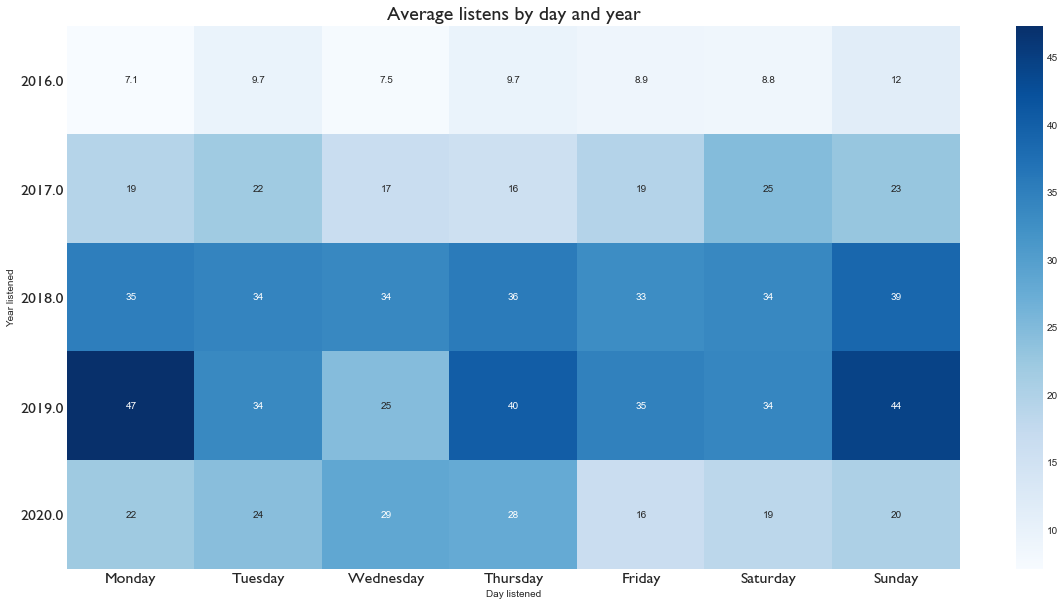

In [161]:
def songs_by_dayyear():

    days_of_week = ('Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday')

    data = (full_songs.groupby(['Year listened', 'Day listened'])['Event Start Timestamp'].count() / (time_range.days / 30)).unstack()
    sb.heatmap(data, cmap='Blues', annot=True)
    plt.xticks(np.arange(7) + 0.5, days_of_week, fontsize=16, fontfamily='Gill Sans MT')
    plt.yticks(fontsize=16, fontfamily='Gill Sans MT', rotation='horizontal')
    plt.title('Average listens by day and year', fontsize=20, fontfamily='Gill Sans MT')

    return plt.show()
songs_by_dayyear()

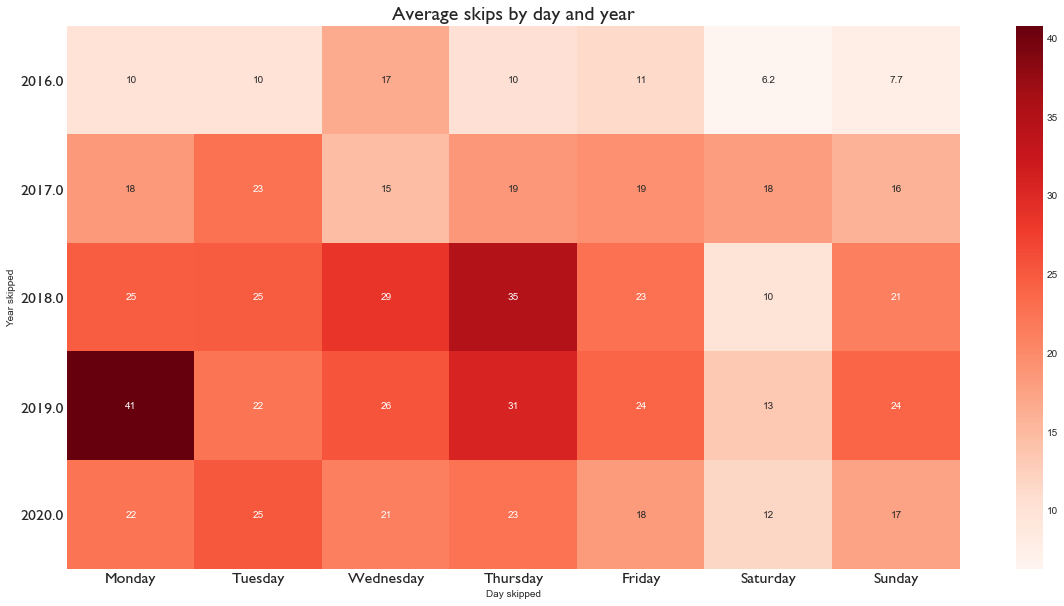

In [160]:
def skips_by_dayyear():

    days_of_week = ('Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday')

    data = (skipped_songs.groupby(['Year skipped', 'Day skipped'])['Event Start Timestamp'].count() / (time_range.days / 30)).unstack()
    sb.heatmap(data, cmap='Reds', annot=True)
    plt.xticks(np.arange(7) + 0.5, days_of_week,fontsize=16, fontfamily='Gill Sans MT')
    plt.yticks(fontsize=16, fontfamily='Gill Sans MT', rotation='horizontal')
    plt.title('Average skips by day and year', fontsize=20, fontfamily='Gill Sans MT')

    return plt.show()
skips_by_dayyear()

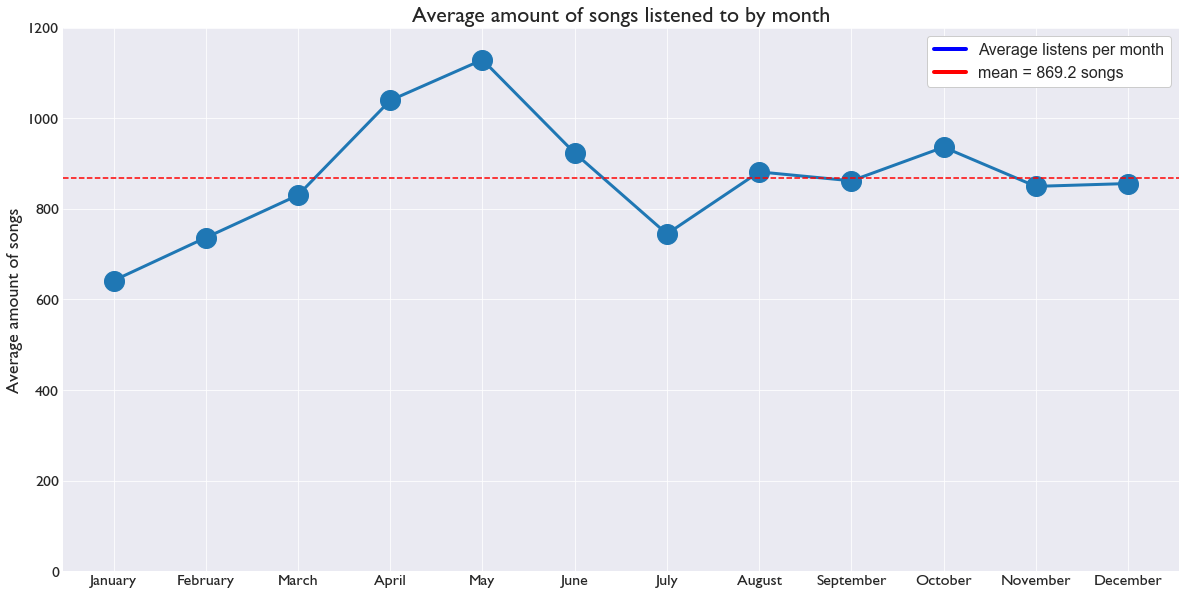

In [159]:
def songs_by_month():
    from matplotlib.lines import Line2D
    average = (full_songs['Event Start Timestamp'].apply(lambda x: x.month).value_counts() / 4).mean()
    legend_lines = [Line2D([0], [0], color='blue', lw=4),
                    Line2D([0], [0], color='red', lw=4)]
    months = ('January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September',                      'October', 'November', 'December')

    (full_songs['Event Start Timestamp'].apply(lambda x: x.month).value_counts() / 4).sort_index().plot(marker= 'o', markersize=20, linewidth=3)
    plt.xticks(np.arange(13)[1:13], months, fontsize=16, family='Gill Sans MT')
    plt.yticks(fontsize=16, family='Gill Sans MT')
    plt.ylabel('Average amount of songs', fontsize=18, family='Gill Sans MT')
    plt.title('Average amount of songs listened to by month', fontsize=22, family='Gill Sans MT')
    plt.axhline(y=average, color='r', linestyle='--')
    plt.grid(True)
    plt.legend(legend_lines, ['Average listens per month', 'mean = {} songs'.format(round(average, 1))], fontsize = 16, frameon=True, facecolor='white', framealpha=1)
    plt.ylim(0, 1200)
    return plt.show()

songs_by_month()

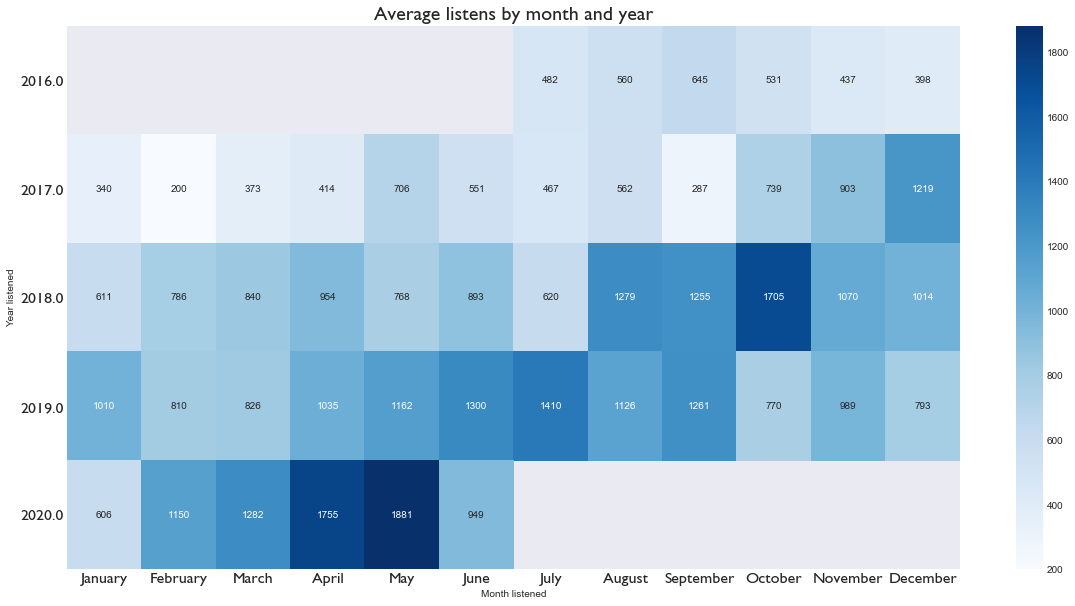

In [156]:
def songs_by_monthyear():

    months = ('January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September',                      'October', 'November', 'December')

    data = full_songs.groupby(['Year listened', 'Month listened'])['Event Start Timestamp'].count().unstack()
    sb.heatmap(data, cmap='Blues', annot=True, fmt='g')
    plt.xticks(np.arange(12) + 0.5, months, fontsize=16, fontfamily='Gill Sans MT')
    plt.yticks(fontsize=16, fontfamily='Gill Sans MT', rotation='horizontal')
    plt.title('Listens by month and year', fontsize=20, fontfamily='Gill Sans MT')

    return plt.show()
songs_by_monthyear()

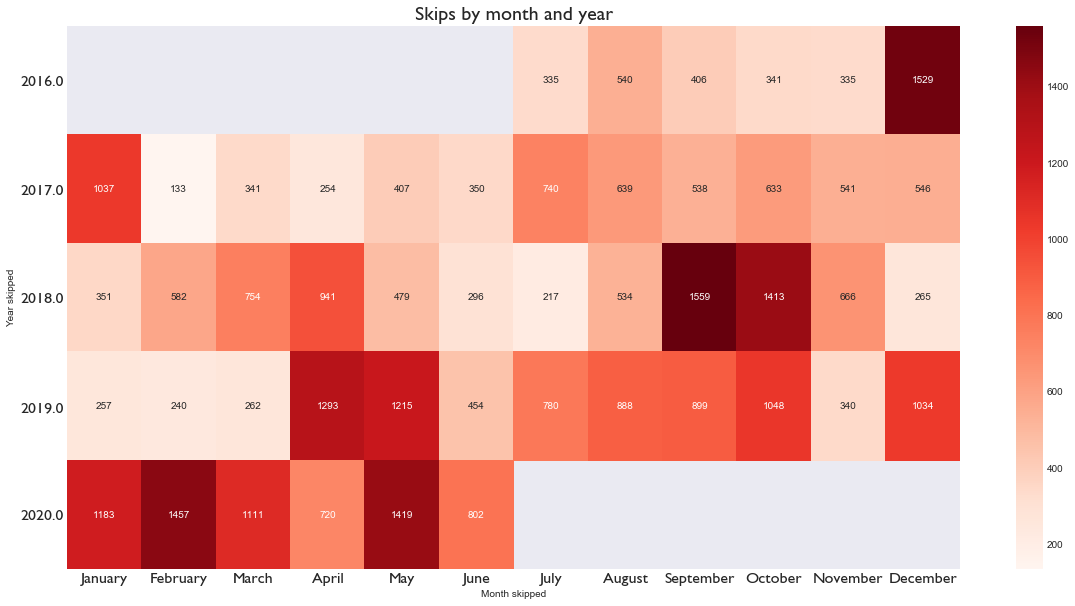

In [157]:
def skips_by_monthyear():

    months = ('January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September',                      'October', 'November', 'December')

    data = skipped_songs.groupby(['Year skipped', 'Month skipped'])['Event Start Timestamp'].count().unstack()
    sb.heatmap(data, cmap='Reds', annot=True, fmt='g')
    plt.xticks(np.arange(12) + 0.5, months, fontsize=16, fontfamily='Gill Sans MT')
    plt.yticks(fontsize=16, fontfamily='Gill Sans MT', rotation='horizontal')
    plt.title('Skips by month and year', fontsize=20, fontfamily='Gill Sans MT')

    return plt.show()
skips_by_monthyear()

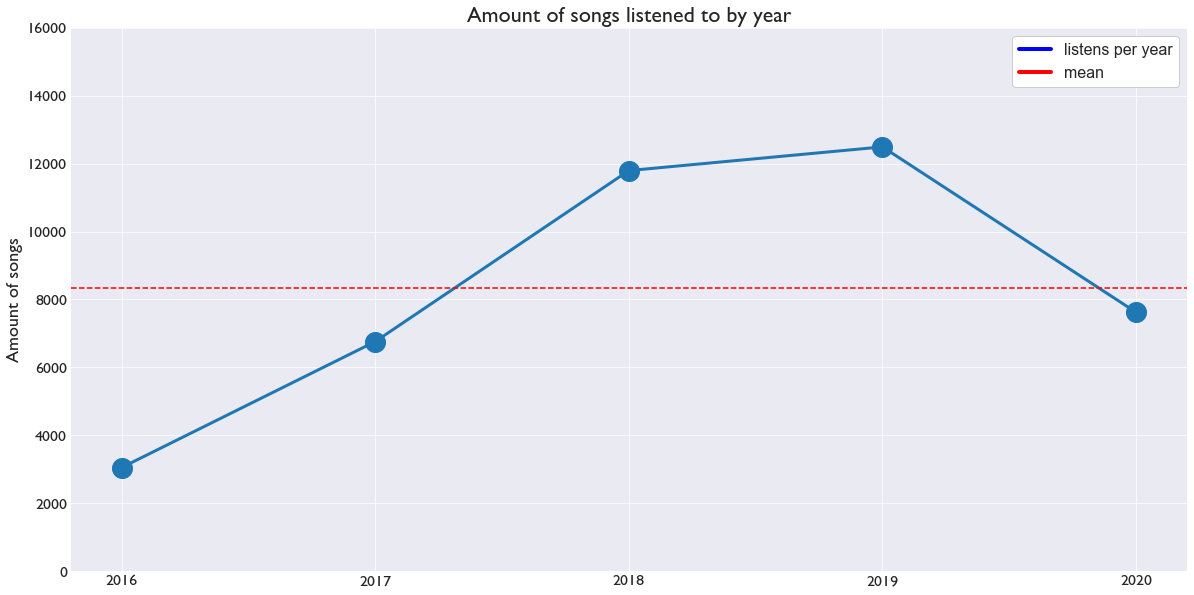

In [23]:
def songs_by_year():
    from matplotlib.lines import Line2D
    average = full_songs['Event Start Timestamp'].apply(lambda x: x.year).value_counts().mean()
    legend_lines = [Line2D([0], [0], color='blue', lw=4),
                    Line2D([0], [0], color='red', lw=4)]
    years = ('2016', '2017', '2018', '2019', '2020')


    full_songs['Event Start Timestamp'].apply(lambda x: x.year).value_counts().sort_index().plot(marker= 'o', markersize=20, linewidth=3)
    plt.ylim(0, 16000)
    plt.xticks(np.arange(2021)[2016:2021], years, fontsize=16, family='Gill Sans MT')
    plt.yticks(fontsize=16, family='Gill Sans MT')
    plt.ylabel('Amount of songs', fontsize=18, family='Gill Sans MT')
    plt.title('Amount of songs listened to by year', fontsize=22, family='Gill Sans MT')
    plt.axhline(y=average, color='r', linestyle='--')
    plt.grid(True)
    plt.legend(legend_lines, ['listens per year', 'mean'], fontsize = 16, frameon=True,                facecolor='white', framealpha=1)
    return plt.show()

songs_by_year()

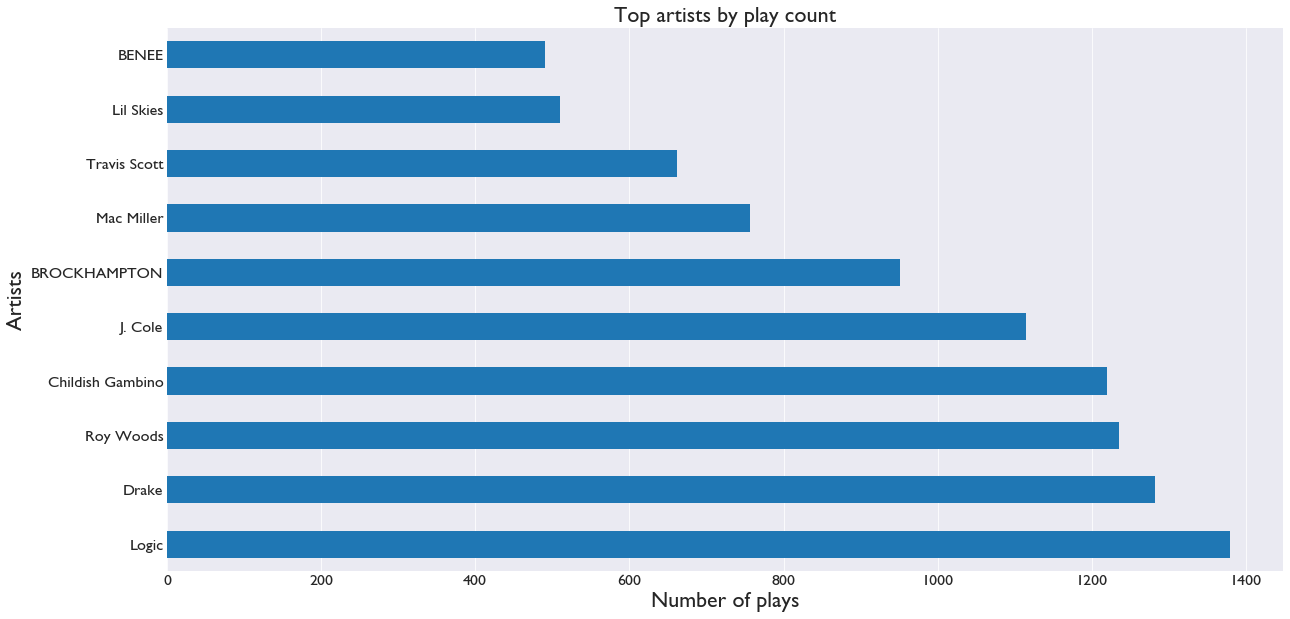

In [24]:
def listened_to_artists():
    listened_to_artists = full_songs['Artist Name'].value_counts()
    listened_to_artists[0:10].plot(kind='barh')
    plt.title('Top artists by play count', fontsize=22, fontfamily='Gill Sans MT')
    plt.ylabel('Artists', fontsize=22, fontfamily='Gill Sans MT')
    plt.xlabel('Number of plays', fontsize=22, fontfamily='Gill Sans MT')
    plt.axes().xaxis.grid()
    plt.xticks(fontsize=16, fontfamily='Gill Sans MT')
    plt.yticks(fontsize=16, fontfamily='Gill Sans MT')
listened_to_artists()

In [25]:
skipped_songs = listening_data[listening_data['End Reason Type'] == 'TRACK_SKIPPED_FORWARDS']
skipped_songs

,Apple Id Number,Apple Music Subscription,Artist Name,Build Version,Client IP Address,Content Name,Content Provider,Content Specific Type,Device Identifier,End Position In Milliseconds,End Reason Type,Event End Timestamp,Event Reason Hint Type,Event Received Timestamp,Event Start Timestamp,Event Type,Feature Name,Genre,Item Type,Media Duration In Milliseconds,Media Type,Metrics Bucket Id,Metrics Client Id,Milliseconds Since Play,Offline,Original Title,Play Duration Milliseconds,Source Type,Start Position In Milliseconds,Store Country Name,UTC Offset In Seconds
4,358953842,True,Coldplay,"Music/3.1 iOS/13.4.1 model/iPhone8,1 hwp/s8000...",2001:8003:30cc:7f00:7d75:97d5:3cd7:c60c,Paradise,The Warner Music Group,Song,458d24b37aa0e1eba6341f6f7ee4c70aee891796,686.0,TRACK_SKIPPED_FORWARDS,2020-06-01T02:04:11.579Z,NOT_SPECIFIED,2020-06-01T02:04:20.803Z,2020-06-01 02:04:10.893000+00:00,PLAY_END,library / songs,Alternative,ITUNES_STORE_CONTENT,277664.0,AUDIO,9278.0,3z3NMROKz46xz4SUzAeXz1GOvIePN9,9224,False,NaN,686.0,ORIGINATING_DEVICE,0,Australia,36000
7,358953842,True,MadeinTYO,"Music/3.1 iOS/12.4 model/iPhone8,1 hwp/s8000 b...",120.18.162.126,Lil Bih (feat. 24hrs),The Warner Music Group,Song,458d24b37aa0e1eba6341f6f7ee4c70aee891796,316.0,TRACK_SKIPPED_FORWARDS,2019-09-03T00:56:33.790Z,NOT_SPECIFIED,2019-09-03T00:56:33.925Z,2019-09-03 00:56:33.474000+00:00,PLAY_END,library / albums,Hip Hop/Rap,ITUNES_STORE_CONTENT,170062.0,AUDIO,4589.0,3z2uIdPHzEsYz59hz9trzygSQbDwM,135,False,NaN,316.0,ORIGINATING_DEVICE,0,Australia,36000
8,358953842,True,Anderson .Paak,"Music/3.1 iOS/12.0 model/iPhone8,1 hwp/s8000 b...",120.18.72.227,Tints (feat. Kendrick Lamar),The Warner Music Group,Song,458d24b37aa0e1eba6341f6f7ee4c70aee891796,2936.0,TRACK_SKIPPED_FORWARDS,2018-11-22T06:01:57.399Z,NOT_SPECIFIED,2018-11-22T06:01:57.627Z,2018-11-22 06:01:54.463000+00:00,PLAY_END,library / playlist_detail,Hip Hop/Rap,ITUNES_STORE_CONTENT,268469.0,AUDIO,3974.0,3z49j34Uz5R4z4iCz9taz1Kn3j664k,228,False,NaN,2936.0,ORIGINATING_DEVICE,0,Australia,39600
9,358953842,True,Logic,"Music/3.1 iOS/12.4.1 model/iPhone8,1 hwp/s8000...",120.18.49.67,Out of Sight,UMG Global,Song,458d24b37aa0e1eba6341f6f7ee4c70aee891796,279.0,TRACK_SKIPPED_FORWARDS,2019-09-10T00:29:10.991Z,NOT_SPECIFIED,2019-09-10T00:45:01.728Z,2019-09-10 00:29:10.712000+00:00,PLAY_END,library / songs,Hip Hop/Rap,ITUNES_STORE_CONTENT,137996.0,AUDIO,4589.0,3z2uIdPHzEsYz59hz9trzygSQbDwM,950737,True,NaN,279.0,ORIGINATING_DEVICE,0,Australia,36000
12,358953842,True,Kendrick Lamar,"Music/3.0 iOS/10.0.1 model/iPhone6,2 hwp/s5l89...",58.166.212.49,i,Universal Music International,Song,79b330a05a148bd8cc479948ccb6f843db1af063,134975.0,TRACK_SKIPPED_FORWARDS,2017-01-10T04:54:31.101Z,NOT_SPECIFIED,2017-01-10T05:36:26.547Z,2017-01-10 04:54:28.213000+00:00,PLAY_END,library / albums,Hip Hop/Rap,ITUNES_STORE_CONTENT,336062.0,AUDIO,1393.0,3z1Cf16Uz8ltz4r5zBt2z1AfCS6iOS,2515446,True,NaN,2888.0,ORIGINATING_DEVICE,132087,Australia,39600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128702,358953842,True,Joey Bada$$,"Music/3.1 iOS/11.4.1 model/iPhone8,1 hwp/s8000...",60.227.47.190,TEMPTATION,The Orchard Enterprises Inc.,Song,458d24b37aa0e1eba6341f6f7ee4c70aee891796,1911.0,TRACK_SKIPPED_FORWARDS,2018-09-25T13:33:47.640Z,NOT_SPECIFIED,2018-09-25T13:33:48.132Z,2018-09-25 13:33:45.729000+00:00,PLAY_END,library / albums,Hip Hop/Rap,ITUNES_STORE_CONTENT,244250.0,AUDIO,6999.0,3z4yEJmpzCpFz5G4z93yzXbi1I7UU,492,False,NaN,1911.0,ORIGINATING_DEVICE,0,Australia,36000
128718,358953842,True,Meek Mill,"Music/3.1 iOS/12.3.1 model/iPhone8,1 hwp/s8000...",129.94.8.214,Going Bad (feat. Drake),The Warner Music Group,Song,458d24b37aa0e1eba6341f6f7ee4c70aee891796,719.0,TRACK_SKIPPED_FORWARDS,2019-07-01T07:28:07.183Z,NOT_SPECIFIED,2019-07-01T07:46:07.367Z,2019-07-01 07:28:06.464000+00:00,PLAY_END,library / albums,Hip Hop/Rap,ITUNES_STORE_CONTENT,180581.0,AUDIO,8552.0,3z3LHatpzH4nz4lsz

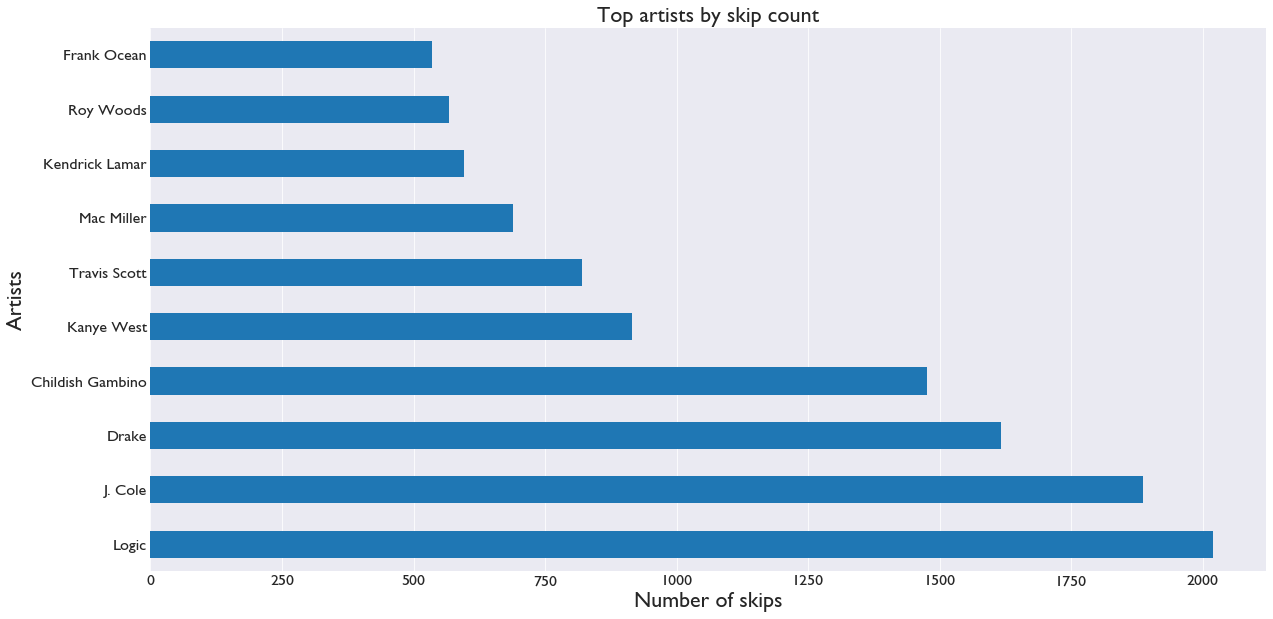

In [26]:
def skipped_artists():
    skipped_artists = skipped_songs['Artist Name'].value_counts()
    skipped_artists[0:10].plot(kind='barh')
    plt.title('Top artists by skip count', fontsize=22, fontfamily='Gill Sans MT')
    plt.ylabel('Artists', fontsize=22, fontfamily='Gill Sans MT')
    plt.xlabel('Number of skips', fontsize=22, fontfamily='Gill Sans MT')
    plt.axes().xaxis.grid()
    plt.xticks(fontsize=16, fontfamily='Gill Sans MT')
    plt.yticks(fontsize=16, fontfamily='Gill Sans MT')
    
    return plt.show()
skipped_artists()

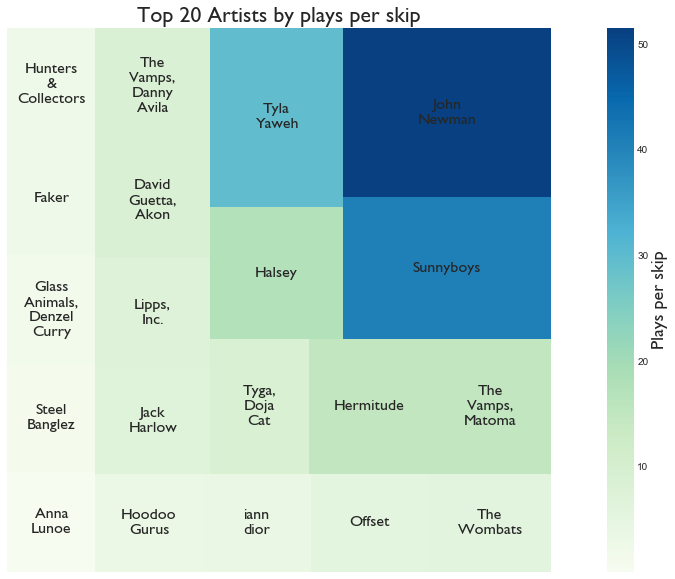

In [158]:
def true_favourite_artists():
    import squarify
    fig, ax = plt.subplots()
    listened = full_songs['Artist Name'].value_counts().sort_index()
    skipped = skipped_songs['Artist Name'].value_counts().sort_index()

    _ = (listened / skipped).dropna().sort_values().to_frame()
    index_values = []
    for i in _.values:
        x = i[0]
        index_values.append(x)
    frame_of_artists = pd.DataFrame({'Artist Name': _.index, 'Index': index_values})
    labels = [x.replace(' ', '\n') for x in frame_of_artists['Artist Name'][-20:]]


    cmap = matplotlib.cm.GnBu
    minima = frame_of_artists['Index'][len(frame_of_artists) - 20]
    maxima = frame_of_artists['Index'][len(frame_of_artists) - 1]
    norm = matplotlib.colors.Normalize(vmin=minima, vmax=maxima, clip=True)
    color_map = [cmap(norm(value)) for value in frame_of_artists['Index'][-20:]]
    squarify.plot(sizes=frame_of_artists['Index'][-20:], label=labels, alpha=1, color=color_map, text_kwargs={'fontsize': 16, 'fontfamily': 'Gill Sans MT'})
    plt.axis('off')
    plt.title('Top 20 Artists by plays per skip', fontsize=22, fontfamily='Gill Sans MT')
    img = plt.imshow([frame_of_artists.Index], cmap=cmap)
    cbar = plt.colorbar(img, orientation='vertical')
    cbar.set_label('Plays per skip', rotation=90, fontsize=18, fontfamily='Gill Sans MT')

    return plt.show()
true_favourite_artists()

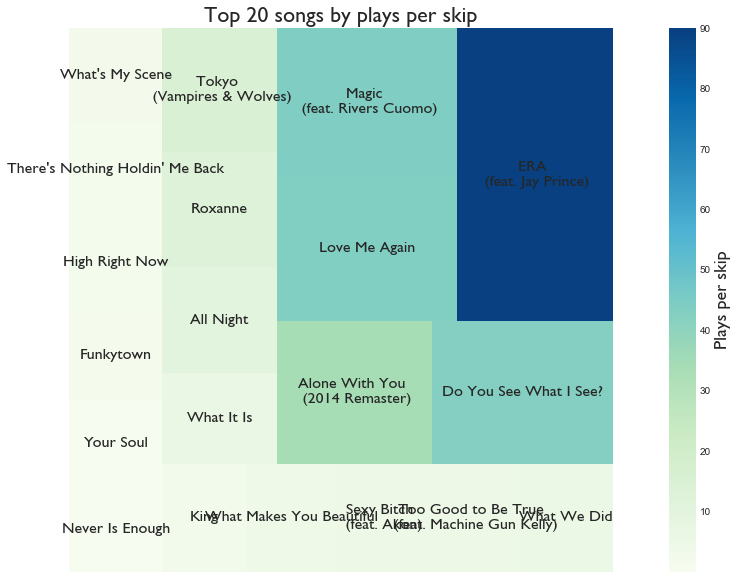

In [28]:
def true_favourite_songs():
    import squarify
    fig, ax = plt.subplots()
    listened_s = full_songs['Content Name'].value_counts().sort_index()
    skipped_s = skipped_songs['Content Name'].value_counts().sort_index()

    _ = (listened_s / skipped_s).dropna().sort_values().to_frame()
    index_values = []
    for i in _.values:
        y = i[0]
        index_values.append(y)
    frame_of_songs = pd.DataFrame({'Song Name': _.index, 'Index': index_values})
    labels = [x.replace('(', '\n (') for x in frame_of_songs['Song Name'][-20:]]

    cmap = matplotlib.cm.GnBu
    minima = frame_of_songs['Index'][len(frame_of_songs) - 20]
    maxima = frame_of_songs['Index'][len(frame_of_songs) - 1]
    norm = matplotlib.colors.Normalize(vmin=minima, vmax=maxima, clip=True)
    color_map = [cmap(norm(value)) for value in frame_of_songs['Index'][-20:]]
    squarify.plot(sizes=frame_of_songs['Index'][-20:], label=labels,           alpha=1, color=color_map, text_kwargs={'fontsize': 16, 'fontfamily': 'Gill Sans MT'})
    plt.axis('off')
    plt.title('Top 20 songs by plays per skip', fontsize=22, fontfamily='Gill Sans MT')
    img = plt.imshow([frame_of_songs.Index], cmap=cmap)
    cbar = plt.colorbar(img, orientation='vertical')
    cbar.set_label('Plays per skip', rotation=90, fontsize=18, fontfamily='Gill Sans MT')

    return plt.show()
true_favourite_songs()

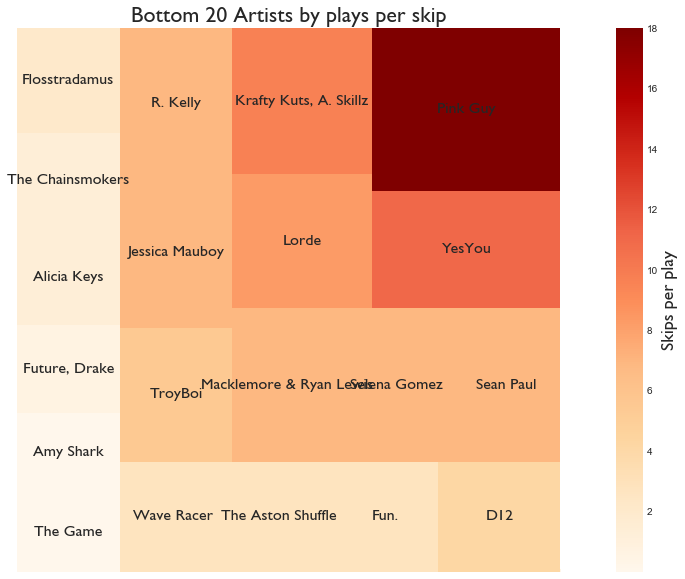

In [29]:
def true_disliked_artists():
    import squarify
    fig, ax = plt.subplots()
    listened = full_songs['Artist Name'].value_counts().sort_index()
    skipped = skipped_songs['Artist Name'].value_counts().sort_index()

    _ = (skipped / listened).dropna().sort_values().to_frame()
    index_values = []
    for i in _.values:
        x = i[0]
        index_values.append(x)
    frame_of_artists = pd.DataFrame({'Artist Name': _.index, 'Index': index_values})
    
    cmap = matplotlib.cm.OrRd
    minima = frame_of_artists['Index'][len(frame_of_artists) - 20]
    maxima = frame_of_artists['Index'][len(frame_of_artists) - 1]
    norm = matplotlib.colors.Normalize(vmin=minima, vmax=maxima, clip=True)
    color_map = [cmap(norm(value)) for value in frame_of_artists['Index'][-20:]]
    squarify.plot(sizes=[0.3 - x for x in frame_of_artists['Index'][-20:]], label=frame_of_artists['Artist Name'][-20:], alpha=1, color=color_map, text_kwargs={'fontsize': 16, 'fontfamily': 'Gill Sans MT'})
    plt.axis('off')
    plt.title('Bottom 20 Artists by skips per play', fontsize=22, fontfamily='Gill Sans MT')
    img = plt.imshow([frame_of_artists.Index], cmap=cmap)
    cbar = plt.colorbar(img, orientation='vertical')
    cbar.set_label('Skips per play', rotation=90, fontsize=18, fontfamily='Gill Sans MT')

    return plt.show()
true_disliked_artists()

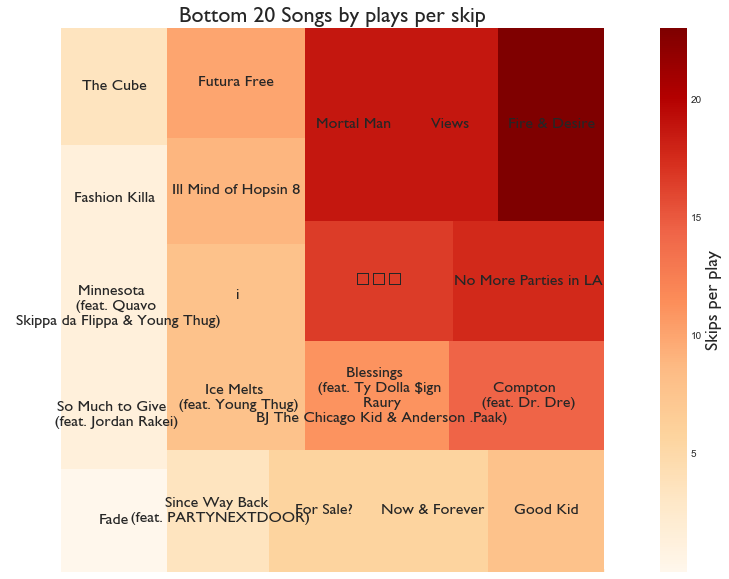

In [44]:
def true_disliked_songs():
    import squarify
    fig, ax = plt.subplots()
    listened_s = full_songs['Content Name'].value_counts().sort_index()
    skipped_s = skipped_songs['Content Name'].value_counts().sort_index()

    _ = (skipped_s / listened_s).dropna().sort_values().to_frame()
    index_values = []
    for i in _.values:
        x = i[0]
        index_values.append(x)
    frame_of_songs = pd.DataFrame({'Content Name': _.index, 'Index': index_values})
    labels = [x.replace('(', '\n (') for x in frame_of_songs['Content Name'][-20:]]
    labels = [x.replace(',', '\n ') for x in labels]

    cmap = matplotlib.cm.OrRd
    minima = frame_of_songs['Index'][len(frame_of_songs) - 20]
    maxima = frame_of_songs['Index'][len(frame_of_songs) - 1]
    norm = matplotlib.colors.Normalize(vmin=minima, vmax=maxima, clip=True)
    color_map = [cmap(norm(value)) for value in frame_of_songs['Index'][-20:]]
    squarify.plot(sizes=frame_of_songs['Index'][-20:], label=labels ,alpha=1, color=color_map, text_kwargs={'fontsize': 16, 'fontfamily': 'Gill Sans MT'})
    plt.axis('off')
    plt.title('Bottom 20 Songs by plays per skip', fontsize=22, fontfamily='Gill Sans MT')
    img = plt.imshow([frame_of_songs.Index], cmap=cmap)
    cbar = plt.colorbar(img, orientation='vertical')
    cbar.set_label('Skips per play', rotation=90, fontsize=18, fontfamily='Gill Sans MT')

    return plt.show()
true_disliked_songs()